# Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import gamma
from pynverse import inversefunc as inv
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
import sys
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid", {'axes.grid' : False})
pd.options.display.float_format = '{:,.8f}'.format


## Functions for reading data and calculating returns

In [3]:
# read prices
def read_stocks_prices(filename: str):
    df_prices = pd.read_excel(filename, index_col=0)
    df_prices.index = pd.to_datetime(df_prices.index)
    df_prices = df_prices.dropna(axis=1)
    stocks = df_prices.columns
    return stocks, df_prices


# calculate normalized prices
def calc_normPrices(df_prices):
    df_normPrices = (df_prices-df_prices.min()) / \
        (df_prices.max()-df_prices.min())
    return df_normPrices


# calculate returns
def calc_returns(df_prices):
    df_returns = df_prices.pct_change().fillna(0)
    return df_returns


# claculate log returns
def calc_logReturns(df_prices):
    df_logReturns = (np.log(df_prices).diff()).fillna(0)
    return df_logReturns


# calculate cumulative log returns
def calc_cumlogReturns(df_prices):
    df_cumlogReturns = (np.log(df_prices).diff().cumsum()
                        ).fillna(0)
    return df_cumlogReturns


## Functions for selecting pairs

In [4]:
# calculate kendalls tau
def calc_tau(stocks: list, df_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculate tau of all the pairs formed by given stocks
    para:
    - stocks: list, list of stocks
    - df_data: pd.Dataframe, time series data to be used for pair trading
    return:
    - df_tau_results: pd.DataFrame, tau values in ascending order
    '''
    df_tau_results = pd.DataFrame(columns=['tau'])
    l = len(stocks)
    for i in range(l-1):
        for j in range(i+1, l):
            if (stocks[i] != stocks[j]) and (f'{stocks[i]}-{stocks[j]}' not in df_tau_results.index):
                df_tau_results.loc[f'{stocks[i]}-{stocks[j]}'] = stats.kendalltau(
                    df_data[stocks[i]], df_data[stocks[j]])[0]
    df_tau_results.sort_values(by='tau', inplace=True)

    return df_tau_results


# parse pairs
def parse_pair(pair: str) -> str:
    '''
    Helper function to parse the pairs' name(str)
    para:
    - pair: str, a pair in the form of 'A-B'
    return:
    - stock_1, stock_2: two stock components of the pair
    '''
    stock_1 = pair[:pair.find('-')]
    stock_2 = pair[pair.find('-')+1:]
    return stock_1, stock_2


# select pairs
def select_pairs(df_data_form: pd.DataFrame, df_tau_results: pd.DataFrame) -> list:
    '''
    Select pairs using various methods
    para:
    - df_data_form: pd.DataFrame, formation data
    - df_tau_results: pd.DataFrame, pairs' tau results calculated by calc_tau(.)
    return:
    - pairs_selected: list, list of pairs formed by the selected stocks
    '''
    def pairs_by_tau(df_tau_results):
        pairs_selected = []
        for pair in df_tau_results.sort_values(by='tau', ascending=False).index:
            # tau
            tau_score = df_tau_results['tau'][pair]
            if tau_score < 0.85:
                break
            pairs_selected.append([pair, tau_score])
        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1], reverse=True))[:, 0]
        return pairs_selected

    def pairs_by_distance(df_data_form, pairs):
        pairs_selected = []
        for pair in pairs:
            stock_1, stock_2 = parse_pair(pair)
            S1_form, S2_form = df_data_form[stock_1], df_data_form[stock_2]
            # distance
            diff = S1_form - S2_form
            distance_score = (diff * diff).sum()
            pairs_selected.append([pair, distance_score])

        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1]))[:, 0]
        return pairs_selected

    def pairs_by_cointegration(df_data_form, pairs):
        pairs_selected = []
        for pair in pairs:
            stock_1, stock_2 = parse_pair(pair)
            S1_form, S2_form = df_data_form[stock_1], df_data_form[stock_2]
            # cointegration
            conin_p_score = coint(S1_form, S2_form)[1]

            if conin_p_score < 0.05:
                pairs_selected.append([pair, conin_p_score])

        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1]))[:, 0]
        return pairs_selected

    def pairs_by_hurst(df_data_form, pairs):

        pairs_selected = []
        for pair in pairs:
            stock_1, stock_2 = parse_pair(pair)
            S1_form, S2_form = df_data_form[stock_1], df_data_form[stock_2]
            # compute spread
            spread_form = S1_form - S2_form
            hurst_score = compute_Hc(spread_form)[0]
            if hurst_score < 0.5:
                pairs_selected.append([pair, hurst_score])

        pairs_selected = np.array(
            sorted(pairs_selected, key=lambda x: x[1]))[:, 0]
        return pairs_selected

    # select pairs using tau
    pairs_1 = pairs_by_tau(df_tau_results)
    # select pairs using distance
    pairs_2 = pairs_by_distance(df_data_form, pairs_1)
    # select pairs using cointegration
    pairs_3 = pairs_by_cointegration(df_data_form, pairs_2)
    # select pairs using hurst
    pairs_4 = pairs_by_hurst(df_data_form, pairs_3)
    print(len(pairs_1), len(pairs_2), len(pairs_3), len(pairs_4))

    return pairs_4

## Functions for fitting Copula family and parameters

In [5]:
from copulae.archimedean import GumbelCopula, FrankCopula, ClaytonCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from scipy.stats import norm
from scipy.stats import t


def fit_copula(df_data: pd.DataFrame, pairs_selected: list) -> pd.DataFrame:
    '''
    Find the best fitted Copula family and corresponding parameters
    para:
    - df_data: pd.DataFrame, fitted data
    - pairs-selected: list, list of selected pairs
    return:
    - df_copula_results, pd.DataFrame, conclusion of fitted results
    '''
    df_copula_results = pd.DataFrame(index=pairs_selected, columns=[
                                     'copula', 'parameter', 'aic', 'bic'])

    for pair in pairs_selected:
        s1, s2 = parse_pair(pair)
        u, v = ECDF(df_data[s1])(df_data[s1]), ECDF(df_data[s2])(df_data[s2])

        data_selected = pd.DataFrame(data={s1: u, s2: v}, columns=[s1, s2])
        _, ndim = data_selected.shape

        best_aic = np.inf

        for copula in [GumbelCopula(dim=ndim), FrankCopula(dim=ndim), ClaytonCopula(dim=ndim), GaussianCopula(dim=ndim), StudentCopula(dim=ndim)]:
            copula.fit(data_selected)
            L = copula.log_lik(data_selected)
            param = copula.params
            num_params = 1
            if isinstance(param, np.ndarray):
                num_params = len(param)
            aic = 2 * num_params - 2 * L
            if aic < best_aic:
                best_aic = aic
                best_bic = num_params * np.log(len(u)) - 2 * L
                best_copula = copula.name

                if isinstance(copula, StudentCopula):
                    best_param = [copula.params[0], copula.params[1][0]]
                else:
                    best_param = copula.params

        df_copula_results.loc[pair] = [
            best_copula, best_param, best_aic, best_bic]
    return df_copula_results


def copula_params(df_data_reform: pd.DataFrame, df_tau_results: pd.DataFrame, pair: str, family: str) -> float:
    '''
    Calculate the parameter Theta of specific copula functions
    para:
    - df_data_reform: pd.DataFrame, data used to re-estimate copula and parameters
    - df_tau_results: pd.DataFrame, tau results of pairs
    - pair: str, specific pair
    - family: str, name of copula function
    return:
    - copula's parameter(s)
    '''
    tau = df_tau_results['tau'][pair]
    rho = np.sin(np.pi/2*tau)

    if family == 'Clayton':
        return 2*tau/float(1-tau)
    elif family == 'Frank':
        def integrand(t): return t/(np.exp(t)-1)
        def frank_fun(theta): return ((tau - 1)/4.0 - (quad(integrand,
                                                            sys.float_info.epsilon, theta)[0]/theta - 1)/theta)**2
        return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x[0]
    elif family == 'Gumbel':
        return 1/(1-tau)
    elif family == 'Gaussian':
        return rho
    elif family == 'Student':
        s1, s2 = parse_pair(pair)
        u, v = ECDF(df_data_reform[s1])(df_data_reform[s1]), ECDF(
            df_data_reform[s2])(df_data_reform[s2])
        data_selected = pd.DataFrame(data={s1: u, s2: v}, columns=[s1, s2])
        copula = StudentCopula(dim=2)
        copula.fit(data_selected)
        L = copula.log_lik(data_selected)
        if isinstance(copula, StudentCopula):
            return [copula.params[0], copula.params[1][0]]


def calc_MPI(family: str, theta: float, U: np.array, V: np.array) -> float:
    '''
    Calculate Mispricing Index, which is the conditional cdf of Copula functions
    para:
    - family: str, copula family name
    - theta: float, parameter of copula function
    - U: np.array, quantile value of stock 1
    - V: np.array, quantile value of stock 2
    return:
    - MPI_u_v: float, conditional cdf of u given v
    - MPI_v_u: float, conditional cdf of v given u
    '''
    if family == 'Clayton':
        A_v = np.power(V, -theta - 1)
        A_u = np.power(U, -theta - 1)
        if (A_v == np.inf).any():
            MPI_u_v = np.zeros(len(V))
        if (A_u == np.inf).any():
            MPI_v_u = np.zeros(len(U))

        B = np.power(V, -theta) + np.power(U, -theta) - 1
        h = np.power(B, (-1 - theta) / theta)
        MPI_u_v = A_v * h
        MPI_v_u = A_u*h

    elif family == 'Frank':
        if theta == 0:
            return V
        else:
            A = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta * V) - 1)
            B = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta * U) - 1)
            C = (np.exp(-theta * U) - 1) * \
                (np.exp(-theta * V) - 1) + (np.exp(-theta) - 1)
            if C == 0.0:
                return 0.5, 0.5
            MPI_u_v = B / C
            MPI_v_u = A / C

    elif family == 'Gumbel':
        if theta == 1:
            return V
        else:
            t1 = np.power(-np.log(U), theta)
            t2 = np.power(-np.log(V), theta)
            p1 = U * V if theta == 1 else np.exp(-np.power(
                np.power(-np.log(U), theta) + np.power(-np.log(V), theta), 1.0 / theta))
            p2 = np.power(t1 + t2, -1 + 1.0 / theta)
            MPI_u_v = p1 * p2 * np.power(-np.log(V), theta - 1) / V
            MPI_v_u = p1 * p2 * np.power(-np.log(U), theta - 1) / U

    elif family == 'Gaussian':
        MPI_u_v = norm.cdf(norm.ppf(U)-theta*norm.ppf(V) / np.sqrt(1-theta**2))
        MPI_v_u = norm.cdf(norm.ppf(V)-theta*norm.ppf(U) / np.sqrt(1-theta**2))

    elif family == 'Student':
        n = theta[0]  # corr
        rho = theta[1]  # df
        MPI_u_v = t.cdf(np.sqrt((n+1) / (n+t.ppf(V, n)**2)) *
                        (t.ppf(U, n)-rho*t.ppf(V, n)) / np.sqrt(1-rho**2), n+1)
        MPI_v_u = t.cdf(np.sqrt((n+1) / (n+t.ppf(U, n)**2)) *
                        (t.ppf(V, n)-rho*t.ppf(U, n)) / np.sqrt(1-rho**2), n+1)
        if MPI_u_v is np.NaN or MPI_v_u is np.NaN:
            print('Error')

    return MPI_u_v, MPI_v_u


 ## Functions for copula-based pair trading formation, re-estimation and trading implementation

In [6]:
def train_test_split(df_data:pd.DataFrame,train_start:datetime.datetime,train_end:datetime.datetime, test_start:datetime.datetime, test_end:datetime.datetime)->pd.DataFrame:
    '''
    Helper function to split the train and test data
    para:
    - df_data: pd.DataFrame, data to be split
    - train_start: datetime.datetime, train start date
    - train_end: datetime.datetime, train end date
    - test_start: datetime.datetime, test start date
    - test_end: datetime.datetime, test end date
    return:
    - df_train: pd.DataFrame, train data
    - df_test: pd.DataFrame, test data
    '''
    df_train = df_data[train_start:train_end]
    df_test = df_data[test_start:test_end]
    return df_train, df_test 


def copula_formation(df_data_form:pd.DataFrame, df_tau_results:pd.DataFrame, pairs_selected:list):
    '''
    Form the copula results
    para:
    - df_data_form: pd.DataFrame, data used to form copula results
    - df_tau_results, pd.DataFrame, calculated tau results of all pairs
    - paris_selected: list, selected pairs
    return:
    - df_copula_results: pd.DataFrame, fitted copula results
    '''
    df_copula_results = fit_copula(df_data_form, pairs_selected)
    df_copula_results = pd.concat([df_copula_results, df_tau_results], axis=1)
    return df_copula_results


def copula_update(df_data_reform:pd.DataFrame, df_copula_results:pd.DataFrame, pair:str):
    '''
    Re-estimate the copula results, especially the parameters
    para:
    - df_data_reform: pd.DataFrame, data used to re-form copula results
    - df_copula_results, pd.DataFrame, preious fitted copula results
    - pair: str, selected pair
    return:
    - df_copula_results: pd.DataFrame, new fitted copula results
    '''
    stocks = list(parse_pair(pair))
    df_tau_results = calc_tau(stocks, df_data_reform)
    family = df_copula_results['copula'][pair]
    theta = copula_params(df_data_reform, df_tau_results, pair, family)
    df_copula_results['parameter'][pair] = theta
    df_copula_results['tau'][pair] = df_tau_results['tau'][pair]

    return df_copula_results


def copula_trading(df_data_form:pd.DataFrame, df_data_trade:pd.DataFrame, df_copula_results:pd.DataFrame, pair:str, threshold:float):
    '''
    Implement trading strategy
    para:
    - df_data_form: pd.DataFrame, data used to form copula
    - df_data_trade: pd.DataFrame, data used to trade
    - df_copula_results: pd.DataFrame, fitted copula results
    - pair: str, selected pair
    - threshold: float, threshod of trading index
    '''
    global df_data
    
    stock_1, stock_2 = parse_pair(pair)
    data_form = df_data_form.loc[:,[stock_1, stock_2]]
    data_trade = df_data_trade.loc[:,[stock_1, stock_2]]
    quantiles_u = ECDF(data_form[stock_1].append(pd.Series([-10**6,10**6])))
    quantiles_v = ECDF(data_form[stock_2].append(pd.Series([-10**6,10**6])))
    family = df_copula_results['copula'][pair]
    theta = df_copula_results['parameter'][pair]
    df_copula_results_cp = df_copula_results.copy()

    quantiles_res = {'Quantile_1':[],'Quantile_2':[]}
    MPI_res = {'MPI_1':[],'MPI_2':[]}
    CMPI_res = {'CMPI_1':[],'CMPI_2':[]}
    df_positions = pd.DataFrame(index=data_trade.index, columns=[
                                    stock_1, stock_2, 'Signal', 'Open/Close'])
    
    long = False
    short = False
    trade_start = df_data_trade.index[0]

    for t in data_trade.index:
        if t == trade_start + relativedelta(months=1):
            df_data_reform = df_data[t-relativedelta(years=3):t]
            df_copula_results_cp = copula_update(df_data_reform, df_copula_results_cp, pair)
            theta = df_copula_results_cp.loc[pair, 'parameter']
            trade_start = t
        # 1. Calculate quantiles of test data according to train data
        u = data_trade.loc[t,stock_1]
        v = data_trade.loc[t,stock_2]
        u_q = quantiles_u(u)
        v_q = quantiles_v(v)

        # 2. Calculate MPI
        MPI_u_v, MPI_v_u = calc_MPI(family, theta, u_q, v_q)
        MPI_u_v -= 0.5
        MPI_v_u -= 0.5

        # 3. Calculate CMPI
        if t == data_trade.index[0]:
            CMPI_u_v = MPI_u_v
            CMPI_v_u = MPI_v_u
        else:
            CMPI_u_v = MPI_u_v + CMPI_res['CMPI_1'][-1]
            CMPI_v_u = MPI_v_u + CMPI_res['CMPI_2'][-1]
            if abs(CMPI_u_v) >= 1.9 or abs(CMPI_v_u) >= 1.9:
                CMPI_u_v = 0.0
                CMPI_v_u = 0.0

        quantiles_res['Quantile_1'].append(u_q)
        quantiles_res['Quantile_2'].append(v_q)
        MPI_res['MPI_1'].append(MPI_u_v)
        MPI_res['MPI_2'].append(MPI_v_u)
        CMPI_res['CMPI_1'].append(CMPI_u_v)
        CMPI_res['CMPI_2'].append(CMPI_v_u)


        # 4. Check trading signals
        if t == df_data_trade.index[-1]:
            df_positions.loc[t] = [0, 0, 'Close', 'Close']
            break
        # if long position is open
        if long:
            if (CMPI_u_v >= 0) or (CMPI_v_u <= 0):
                df_positions.loc[t] = [0, 0, 'Close', 'Close']
                long = False
            else:
                df_positions.loc[t] = [1, -1, 'Hold', 'Open']
        # if short position is open
        elif short:
            if (CMPI_u_v <= 0) or (CMPI_v_u >= 0):
                df_positions.loc[t] = [0, 0, 'Close', 'Close']
                short = False
            else:
                df_positions.loc[t] = [-1, 1, 'Hold', 'Open']
        # if no positions are open
        else:
            # Long asset1 is undervalued(CMPI<-0.6 / MPI<-0.45) and short asset2 is overvalued(CMPI>0.6 / MPI>0.45)
            if (CMPI_u_v < -threshold) or (CMPI_v_u > threshold):
                # long asset1 and short asset2
                df_positions.loc[t] = [1, -1, 'Buy', 'Open']
                long = True
            # short asset1 is overvalued(CMPI>0.6 / MPI>0.45)) and long asset2 is undervalued(CMPI<-0.6 / MPI<-0.45)
            elif (CMPI_u_v > threshold) or (CMPI_v_u < -threshold):
                # short asset1 and long asset2
                df_positions.loc[t] = [-1, 1, 'Sell', 'Open']
                short = True
            else:
                df_positions.loc[t] = [0, 0, 'Hold', 'Close']

    calculations_res = {**quantiles_res, **MPI_res, **CMPI_res}
    df_calculations = pd.DataFrame(calculations_res, index=data_trade.index)
    df_calculations.columns = ['Quantile_'+stock_1, 'Quantile_'+stock_2, 'MPI_'+stock_1, 'MPI_'+stock_2, 'CMPI_'+stock_1, 'CMPI_'+stock_2]

    df_returns = df_positions[[stock_1, stock_2]].shift() * (np.exp(data_trade)-1)
    df_returns.columns = ['Return_'+stock_1, 'Return_'+stock_2]

    df_positions.columns = ['Position_'+stock_1, 'Position_'+stock_2, 'Signal', 'Open/Close']
    print('Positions table:\n', df_positions.loc[df_positions['Signal']!='Hold',:])

    return df_calculations, df_positions, df_returns.dropna()
        

## Functions for measuring performance

In [7]:
def metrics(df_return):
    '''
    Measure trading performance
    para:
    - df_return: pd.DataFrame, trading returns of a pair
    return:
    - df_performance_metrics: pd.DataFrame, performance metrics 
    '''
    # 1. Total cumulative return
    cum_return_df = pd.Series(np.cumprod(df_return+1))
    total_cum_return = cum_return_df[-1]-1

    # 2. Winning rate
    winning_rate = len(df_return[df_return > 0])/len(df_return)

    # 3. Maximum number of consecutive losses
    counter = 0
    max_score = 0
    for p in df_return:
        if p < 0:
            counter += 1
        else:
            if counter > 0:
                max_score = max(max_score, counter)
            counter = 0
    max_score = max(max_score, counter)

    # 4. Max drawdown
    max_drawdown = np.max(
        1 - cum_return_df/np.maximum.accumulate(cum_return_df))

    # 5. Sharpe Ratio
    sharpe_ratio = np.mean(df_return)/np.std(df_return) * \
        np.sqrt(252) if np.std(df_return) != 0.0 else 0.0

    # 6. Sortino Ratio
    mean = np.mean(df_return)
    cum = 0
    for item in df_return:
        if item < mean:
            cum = cum + (item - mean) ** 2
    downdev = np.sqrt(cum/len(df_return))
    sortino_ratio = np.mean(df_return) / downdev

    metrics_res = {'Cumulative Return': [total_cum_return], 'Sharpe Ratio': [sharpe_ratio], 'Max Drawdown': [max_drawdown],
                   'Maxnum Consecutive Losses': [max_score], 'Winning Rate': [winning_rate],
                   'Sortino Ratio': [sortino_ratio]}
    df_performance_metrics = pd.DataFrame(data=metrics_res, index=['Metrics'])

    return df_performance_metrics

# Implementation

## Read and preprocess data

In [8]:
filename = '2006_2022_Prices.xlsx'
stocks, df_prices = read_stocks_prices(filename)
df_data = calc_logReturns(df_prices)

form_start = datetime.datetime(2019, 1, 1)
form_end = datetime.datetime(2022, 1, 1)
trade_start = datetime.datetime(2022, 1, 1)
trade_end = datetime.datetime(2023, 1, 1)
df_data_form, df_data_trade = train_test_split(
    df_data, form_start, form_end, trade_start, trade_end)

## Select pairs

In [9]:
df_tau_results = calc_tau(stocks, df_data_form)
pairs_selected = select_pairs(df_data_form, df_tau_results)

pairs_selected


10 10 10 10


array(['^IMUS-^OEX', '^DJUSL-^IMUS', '^DJUSS-^MID', '^DJUSL-^XII',
       '^DJUS-^DJUSL', '^DJUS-^OEX', '^IMUS-^XII', '^OEX-^XII',
       '^DJUSL-^OEX', '^DJGSP-^HUI'], dtype='<U32')

## Visualize Quantile-Quantile relationship and distribution of formation data 

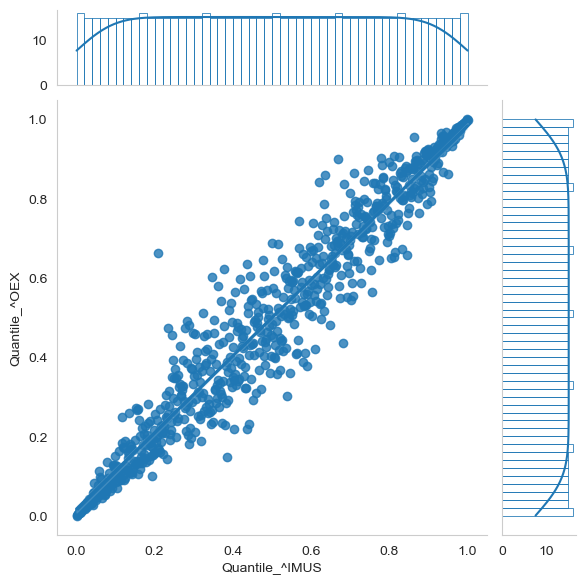

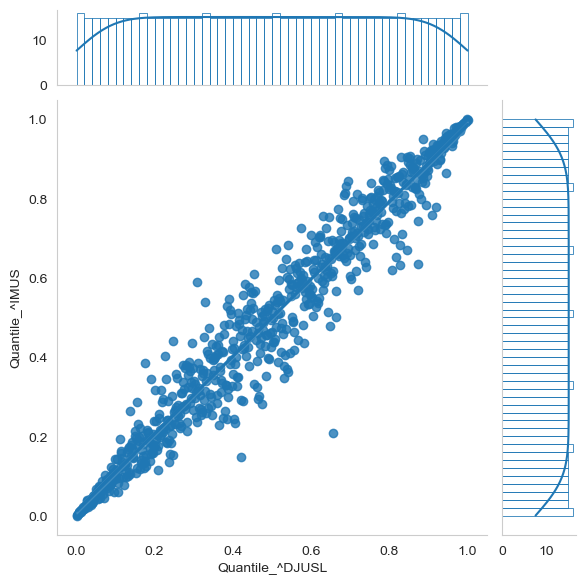

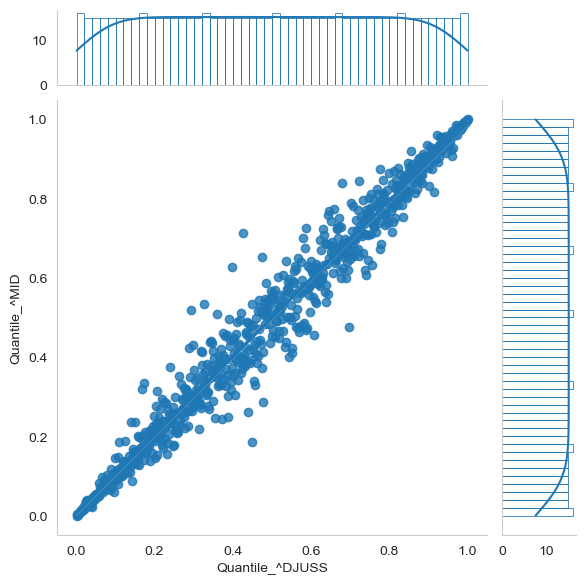

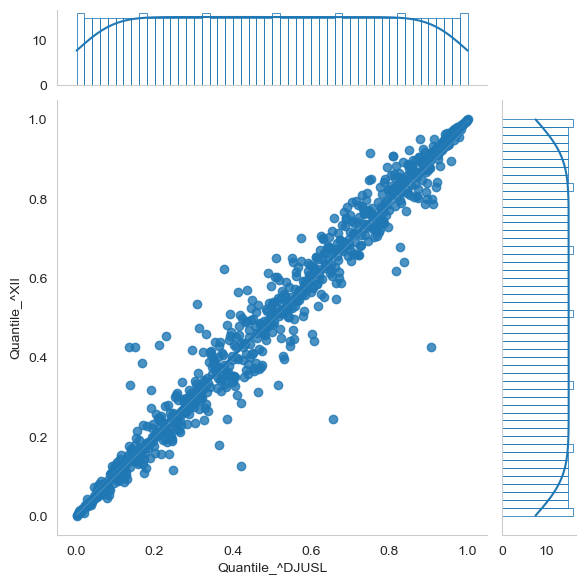

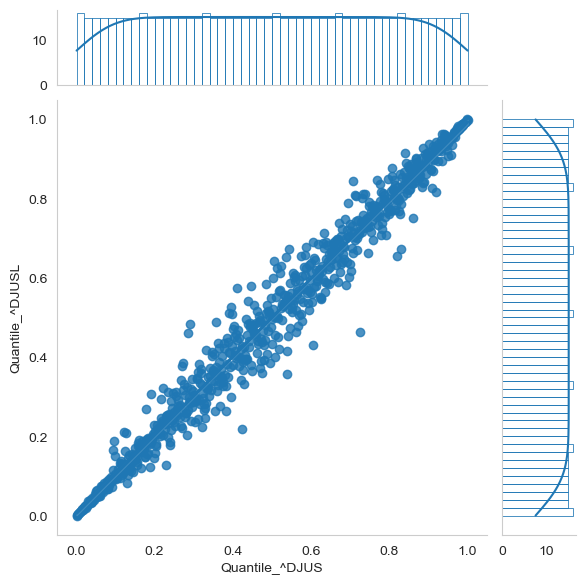

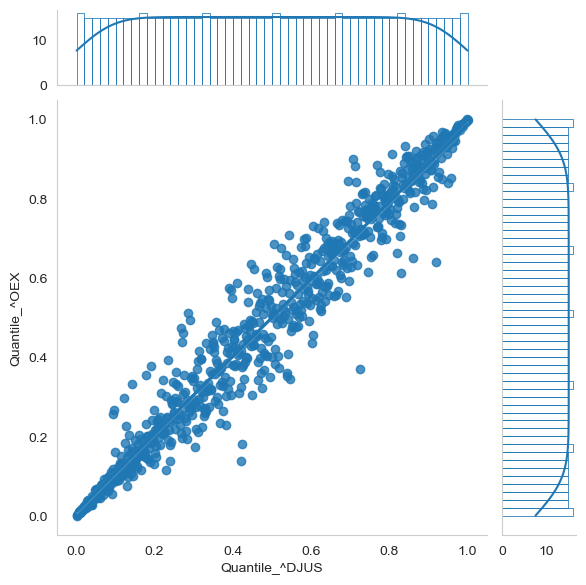

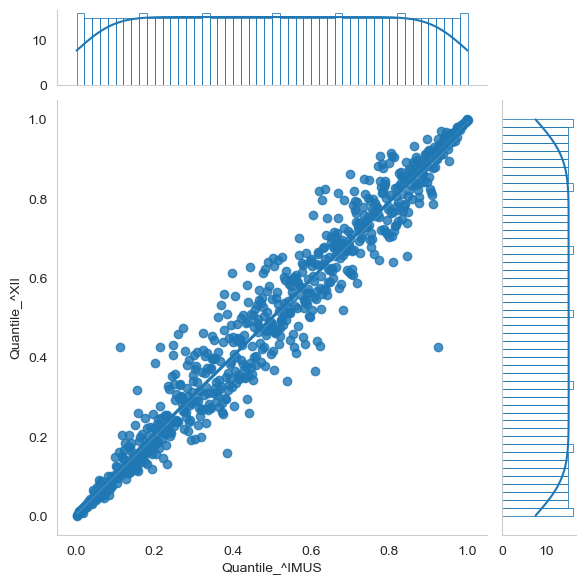

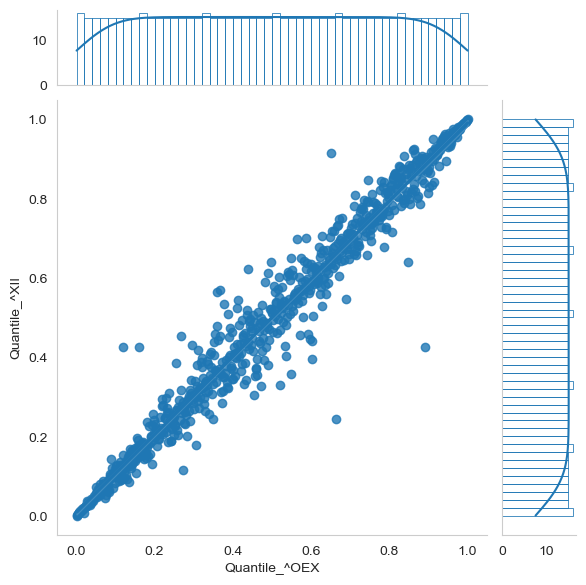

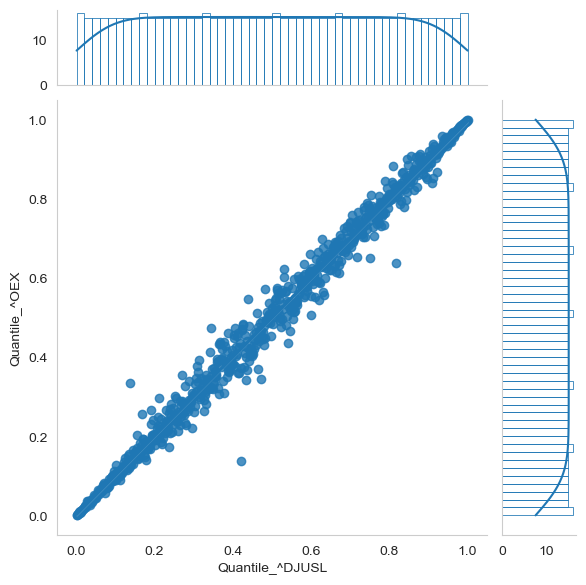

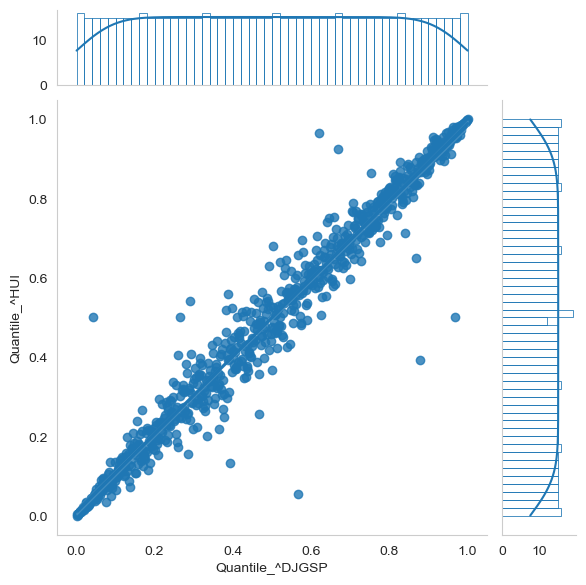

In [20]:
for pair in pairs_selected:
    stock_1, stock_2 = parse_pair(pair)
    quantiles_1 = ECDF(df_data_form[stock_1])(df_data_form[stock_1])
    quantiles_2 = ECDF(df_data_form[stock_2])(df_data_form[stock_2])
    df_QQ = pd.DataFrame(data=list(zip(quantiles_1, quantiles_2)), columns=[
                         "Quantile_"+stock_1, "Quantile_"+stock_2])
    sns.jointplot(data=df_QQ, x="Quantile_"+stock_1, y="Quantile_" +
                  stock_2, kind="reg", marginal_ticks=True, marginal_kws=dict(bins=50, fill=False))
    


## Fit copula

In [11]:
df_copula_results = copula_formation(
    df_data_form, df_tau_results.loc[pairs_selected], pairs_selected)

df_copula_results.to_excel('Copula_Result.xlsx')
df_copula_results


             ^IMUS         ^OEX
count 757.00000000 757.00000000
mean    0.50000000   0.50000000
std     0.28848465   0.28848465
min     0.00131926   0.00131926
25%     0.25065963   0.25065963
50%     0.50000000   0.50000000
75%     0.74934037   0.74934037
max     0.99868074   0.99868074
             ^IMUS         ^OEX
count 757.00000000 757.00000000
mean    0.50000000   0.50000000
std     0.28848465   0.28848465
min     0.00131926   0.00131926
25%     0.25065963   0.25065963
50%     0.50000000   0.50000000
75%     0.74934037   0.74934037
max     0.99868074   0.99868074
             ^IMUS         ^OEX
count 757.00000000 757.00000000
mean    0.50000000   0.50000000
std     0.28848465   0.28848465
min     0.00131926   0.00131926
25%     0.25065963   0.25065963
50%     0.50000000   0.50000000
75%     0.74934037   0.74934037
max     0.99868074   0.99868074
             ^IMUS         ^OEX
count 757.00000000 757.00000000
mean    0.50000000   0.50000000
std     0.28848465   0.28848465
min     

copula                                     parameter  \
^IMUS-^OEX    Student    [9.45849054190262e-07, 0.9752018554352325]   
^DJUSL-^IMUS  Student  [2.6567188449178047e-09, 0.9999945429967577]   
^DJUSS-^MID     Frank                                   38.15915973   
^DJUSL-^XII     Frank                                   38.03948781   
^DJUS-^DJUSL    Frank                                   43.29125466   
^DJUS-^OEX    Student   [1.900885123617968e-05, 0.9821055861686417]   
^IMUS-^XII    Student  [2.3086690692508682e-06, 0.9831930265262541]   
^OEX-^XII       Frank                                   39.23818362   
^DJUSL-^OEX     Frank                                   66.26522391   
^DJGSP-^HUI     Frank                                   38.13960602   

                          aic              bic        tau  
^IMUS-^OEX   -21,128.98731651 -21,124.35795326 0.85206852  
^DJUSL-^IMUS -35,520.43526867 -35,515.80590541 0.87243575  
^DJUSS-^MID              -inf             -inf 0.89969456  
^DJUSL-^XII              -inf             -inf 0.89460165  
^DJUS-^DJUSL             -inf             -inf 0.91111340  
^DJUS-^OEX   -16,126.51998479 -16,121.89062153 0.87017619  
^IMUS-^XII   -20,070.35557154 -20,065.72620828 0.87200456  
^OEX-^XII                -inf             -inf 0.90233205  
^DJUSL-^OEX              -inf             -inf 0.94113495  
^DJGSP-^HUI              -inf             -inf 0.89964545

## Implement trading strategy to all selected pairs & Visualize the trading outcome

             ^IMUS         ^OEX
count 758.00000000 758.00000000
mean    0.50000000   0.50000000
std     0.28848490   0.28848490
min     0.00131752   0.00131752
25%     0.25065876   0.25065876
50%     0.50000000   0.50000000
75%     0.74934124   0.74934124
max     0.99868248   0.99868248
             ^IMUS         ^OEX
count 758.00000000 758.00000000
mean    0.50000000   0.50000000
std     0.28848490   0.28848490
min     0.00131752   0.00131752
25%     0.25065876   0.25065876
50%     0.50000000   0.50000000
75%     0.74934124   0.74934124
max     0.99868248   0.99868248
Positions table:
            Position_^IMUS Position_^OEX Signal Open/Close
Date                                                     
2022-01-24             -1             1   Sell       Open
2022-03-07              0             0  Close      Close
2022-03-08             -1             1   Sell       Open
2022-03-09              0             0  Close      Close
2022-03-10             -1             1   Sell       Open


{'^IMUS-^OEX': {'calculations':             Quantile_^IMUS  Quantile_^OEX   MPI_^IMUS    MPI_^OEX  CMPI_^IMUS  \
  Date                                                                            
  2022-01-03      0.63109354     0.87220026  0.03551784  0.03551784  0.03551784   
  2022-01-04      0.14361001     0.28063241 -0.03551784 -0.03551784  0.00000000   
  2022-01-05      0.03293808     0.04611331 -0.03551784 -0.03551784 -0.03551784   
  2022-01-06      0.30830040     0.30303030 -0.03551784 -0.03551784 -0.07103569   
  2022-01-07      0.14361001     0.28458498 -0.03551784 -0.03551784 -0.10655353   
  ...                    ...            ...         ...         ...         ...   
  2022-12-23      0.61660079     0.68774704  0.03786953  0.03786953 -0.10591244   
  2022-12-27      0.18181818     0.18708827 -0.03786953 -0.03786953 -0.14378197   
  2022-12-28      0.09354414     0.09222661 -0.03786953 -0.03786953 -0.18165149   
  2022-12-29      0.96442688     0.96047431  0.03786953  

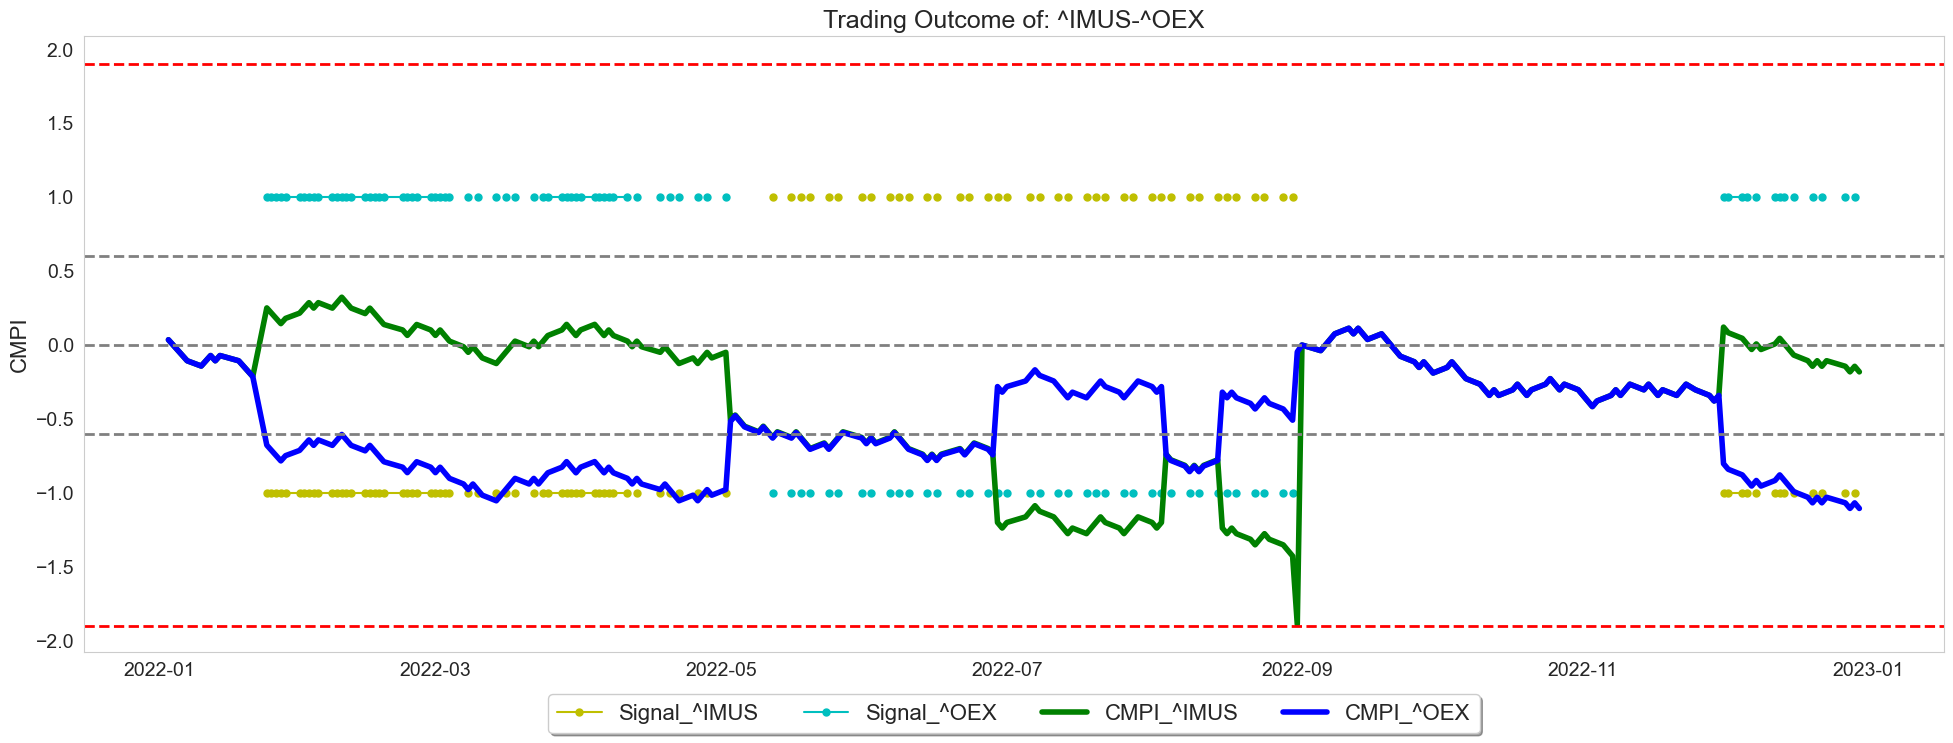

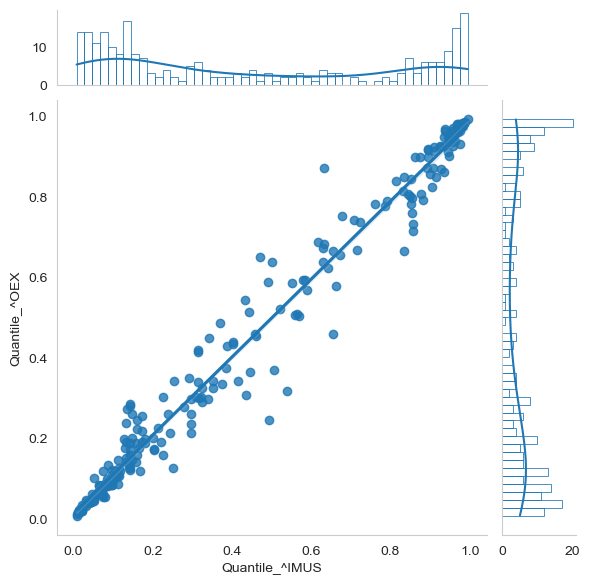

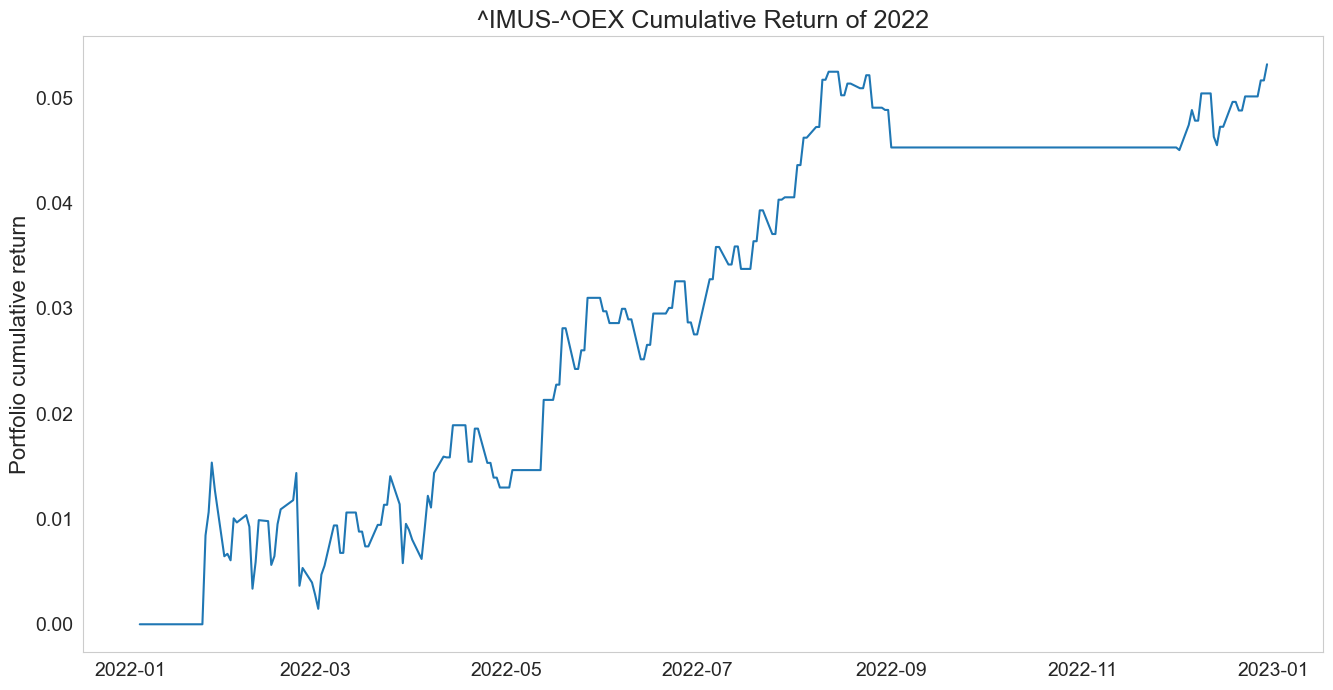

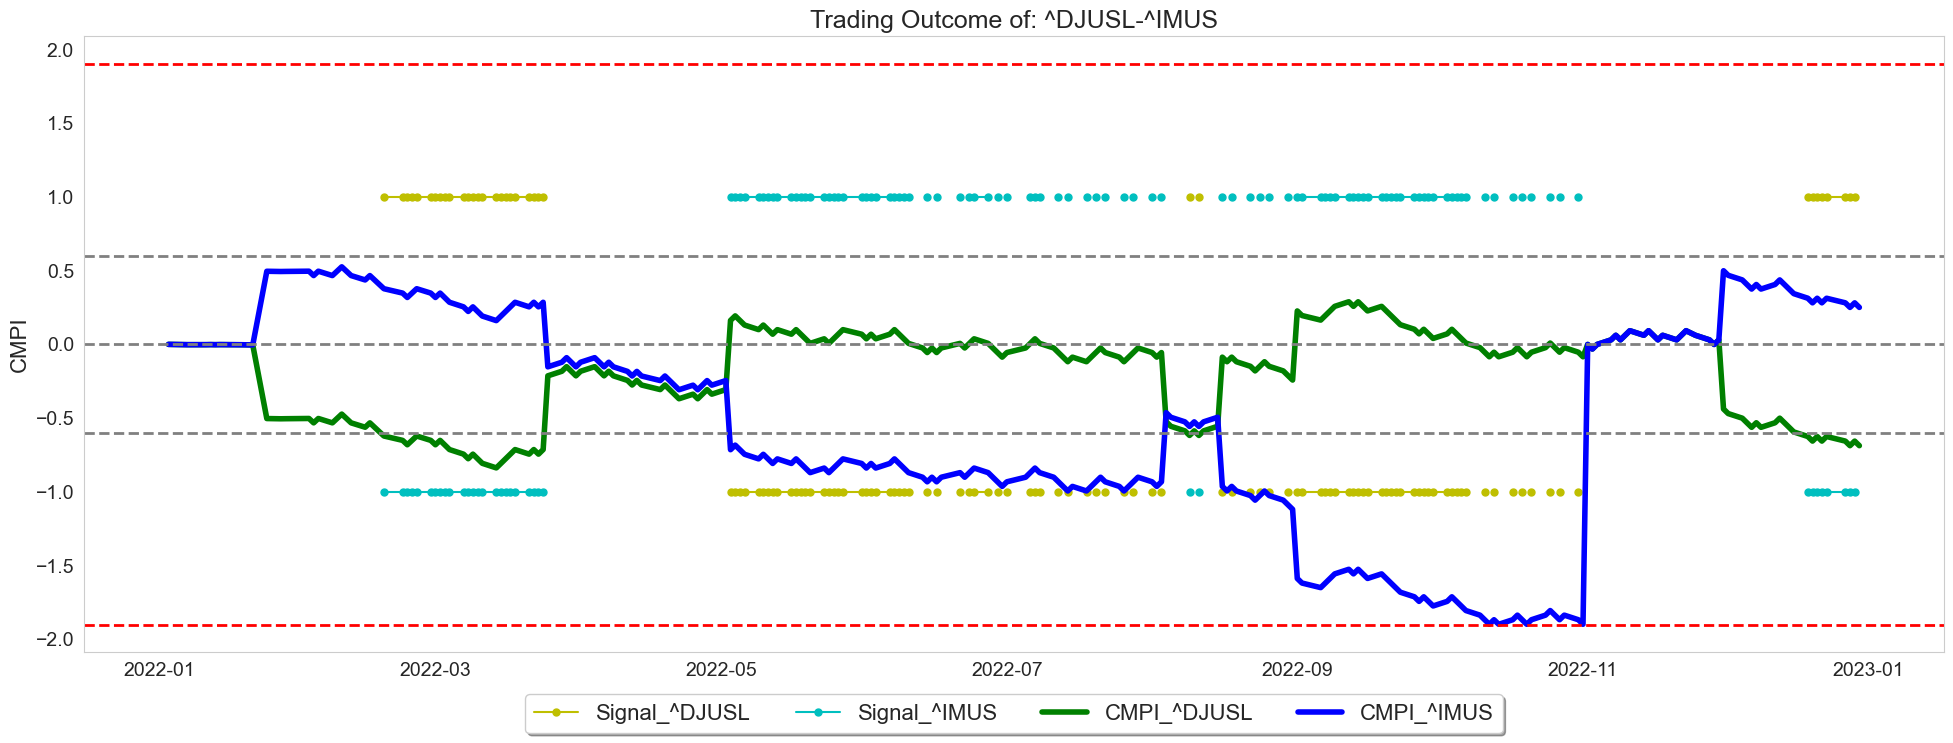

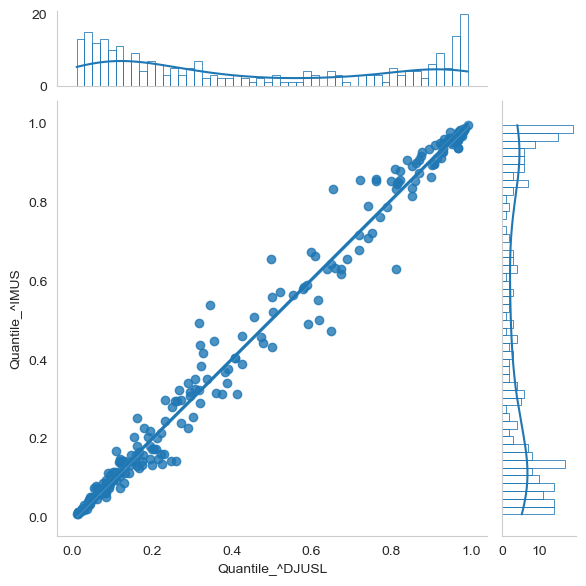

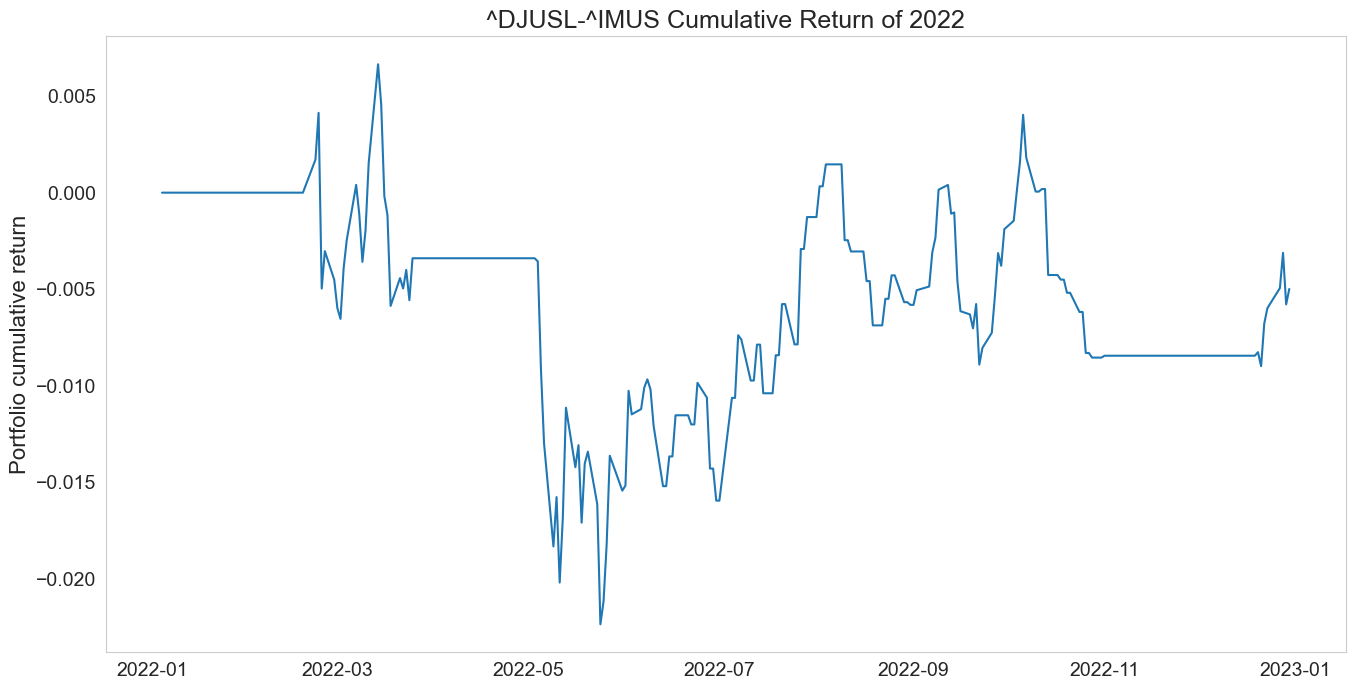

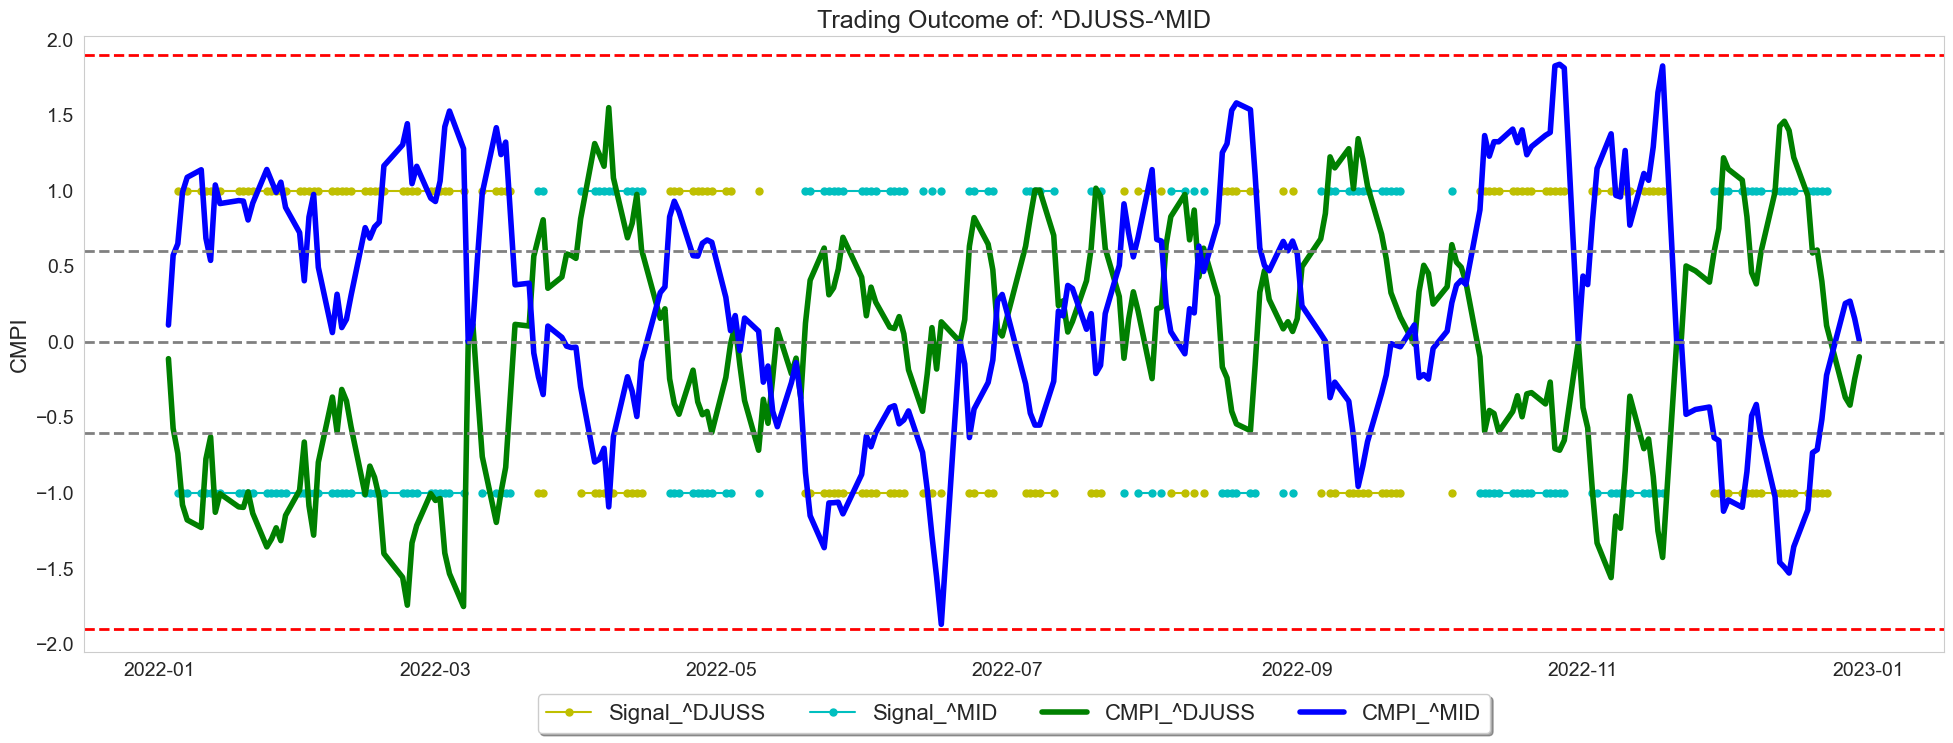

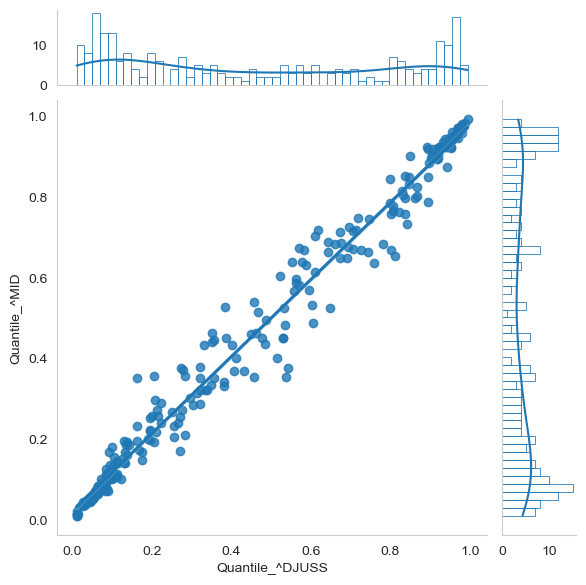

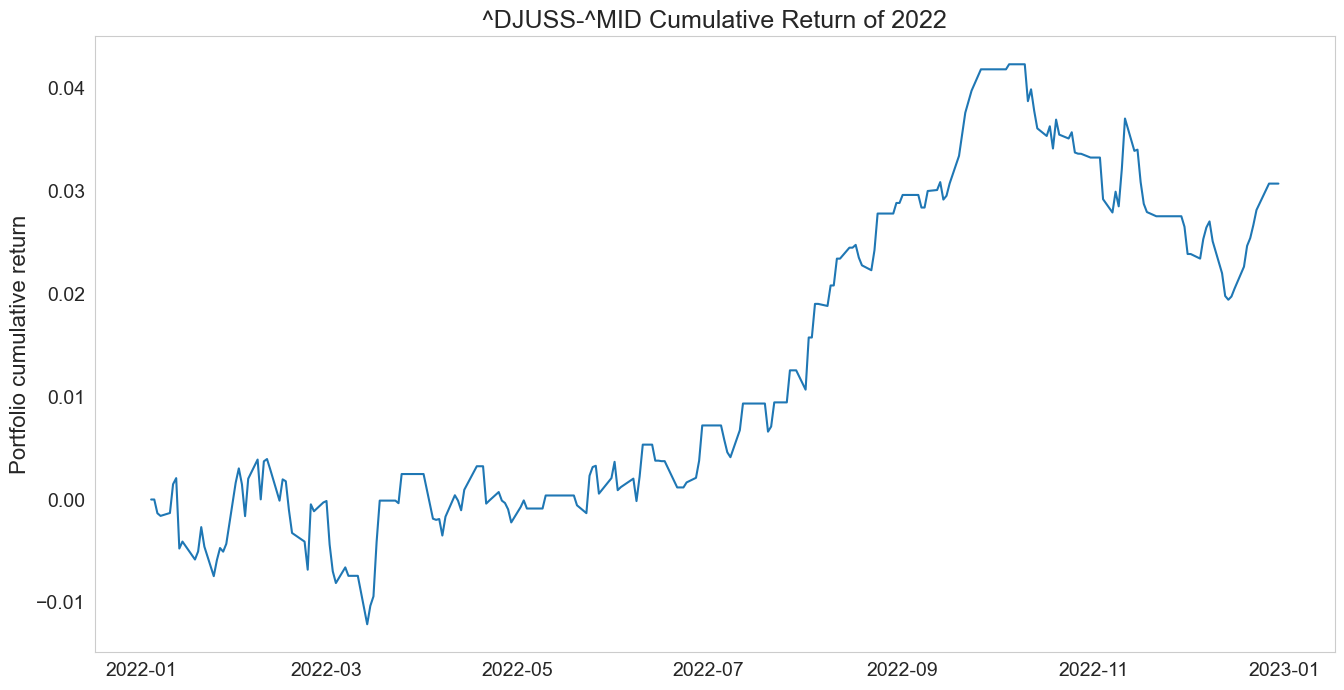

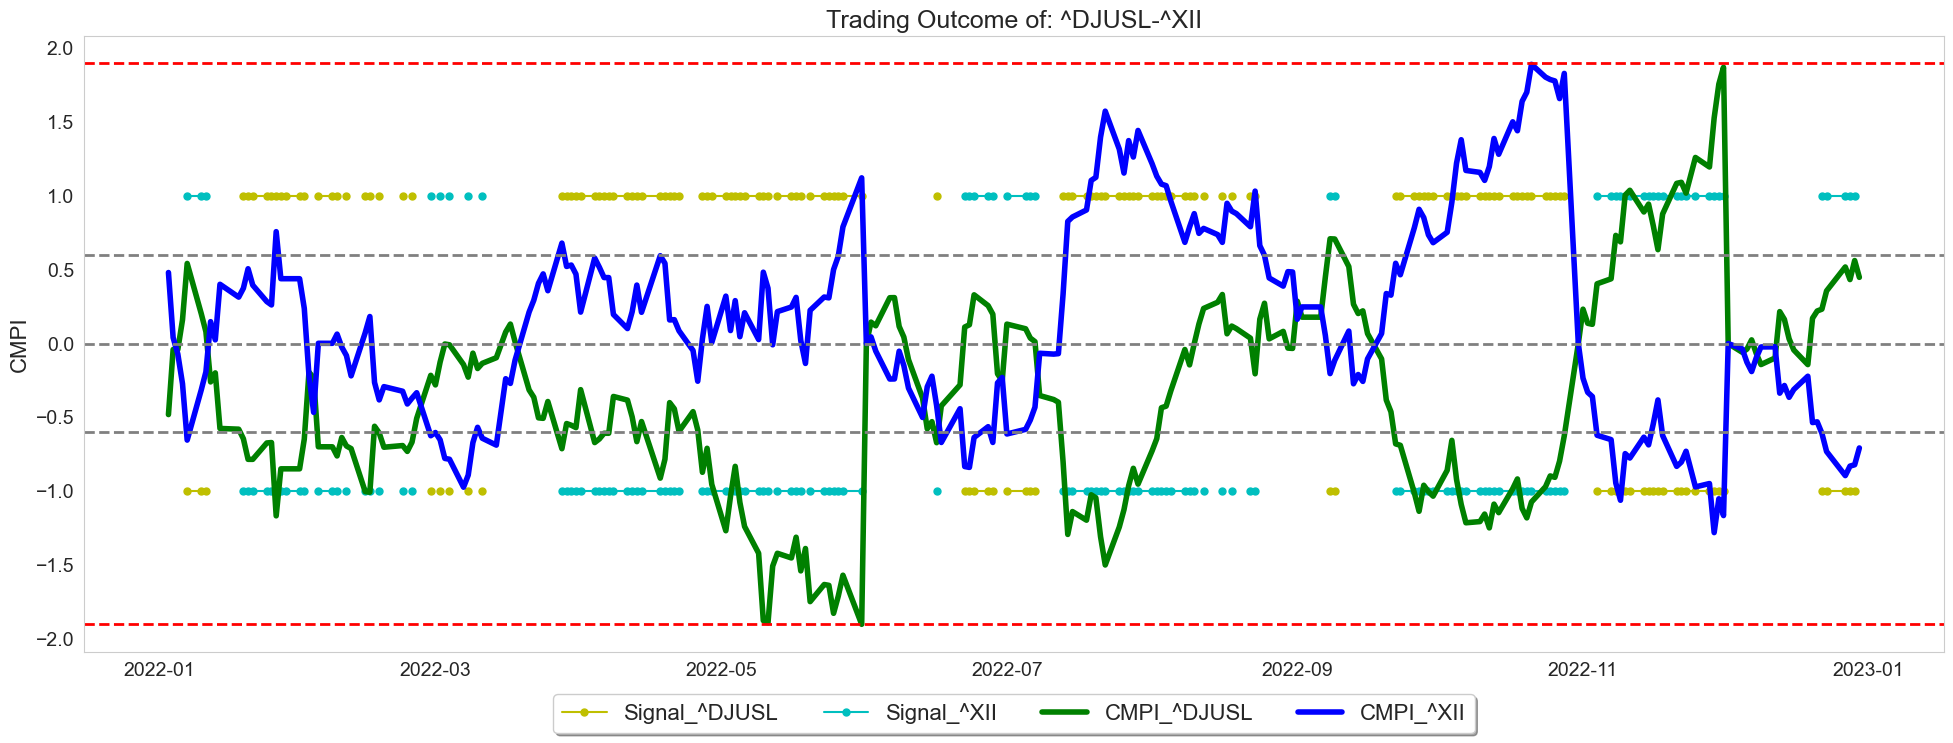

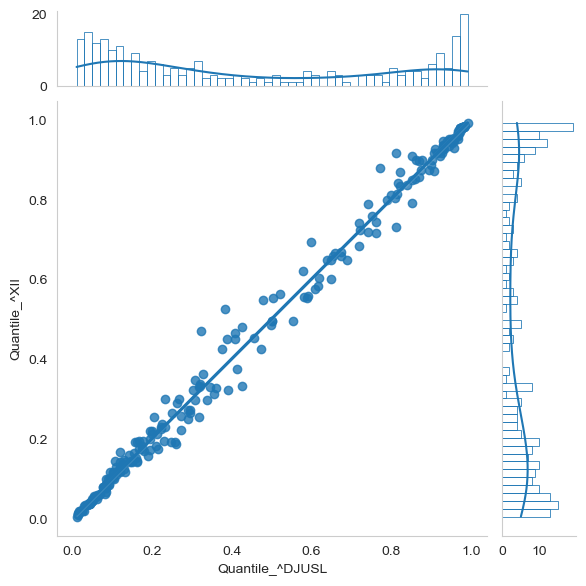

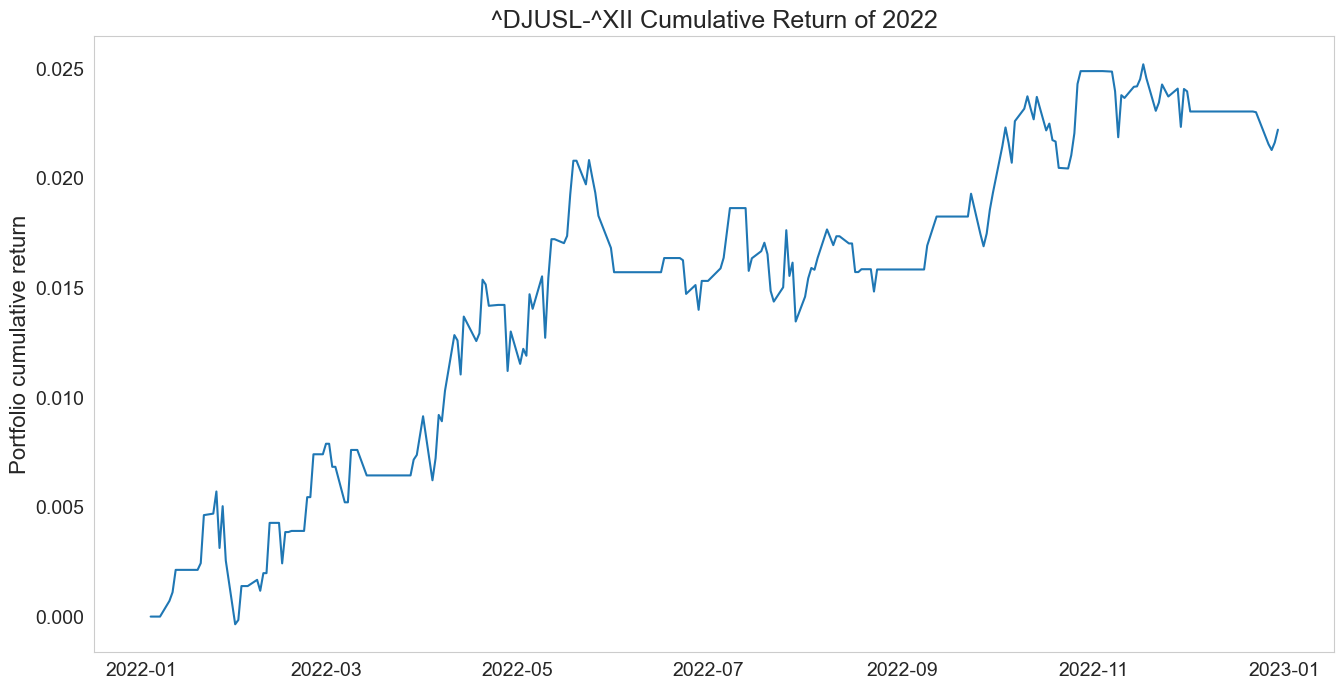

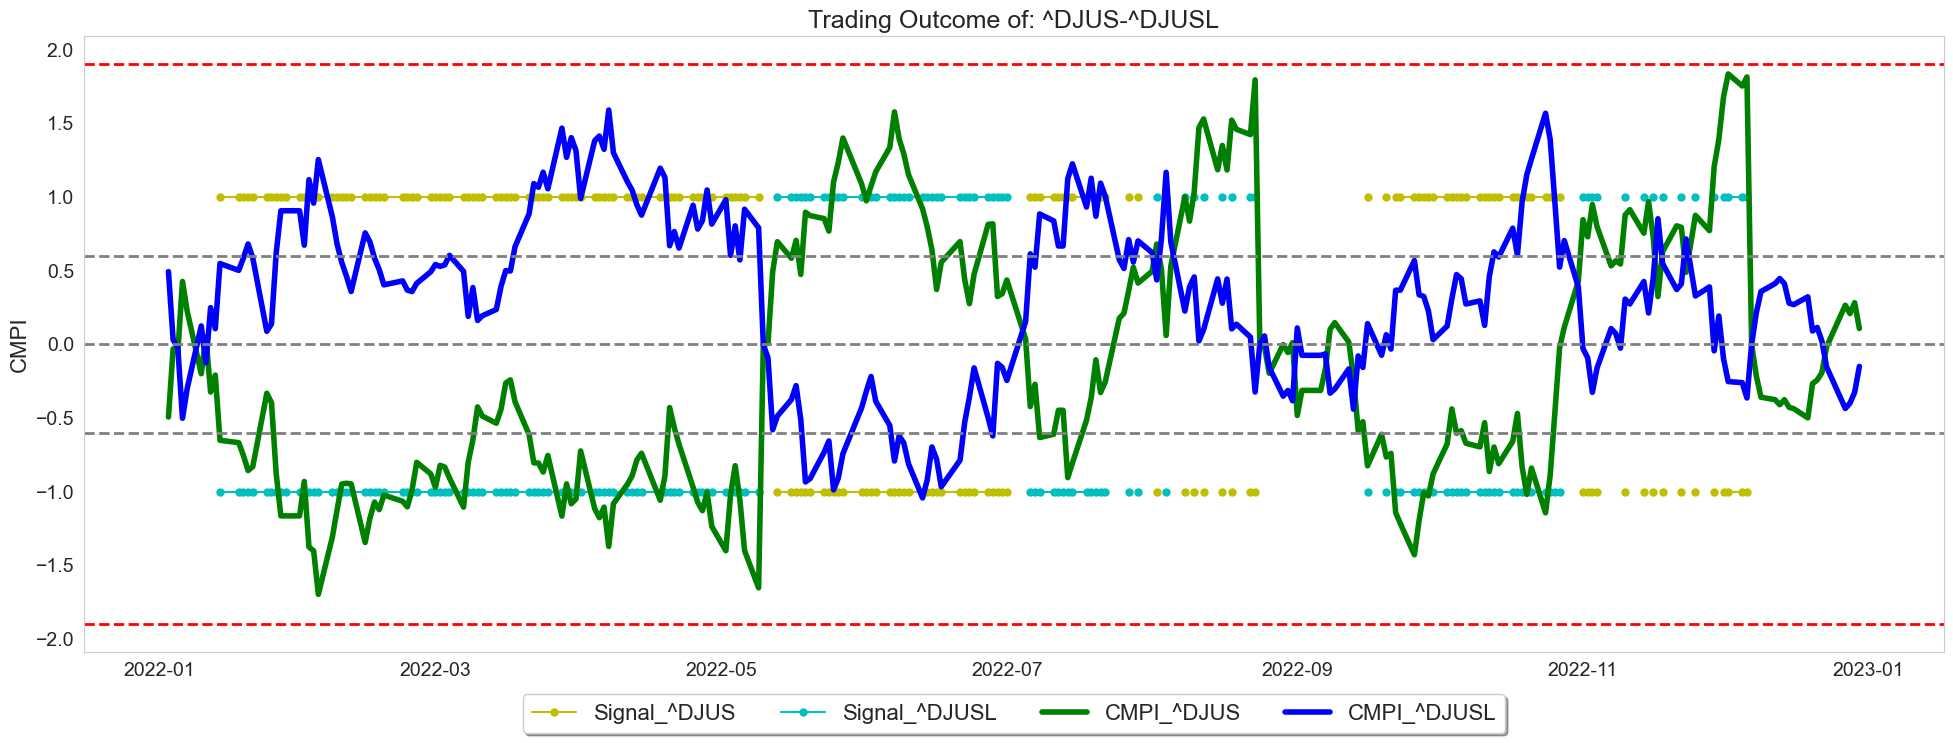

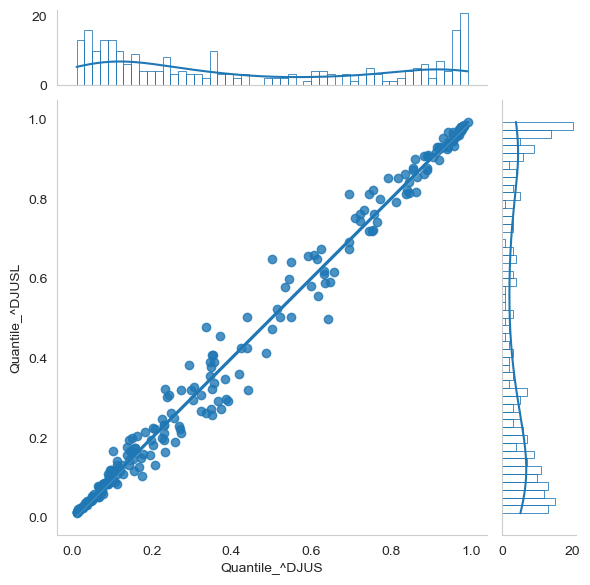

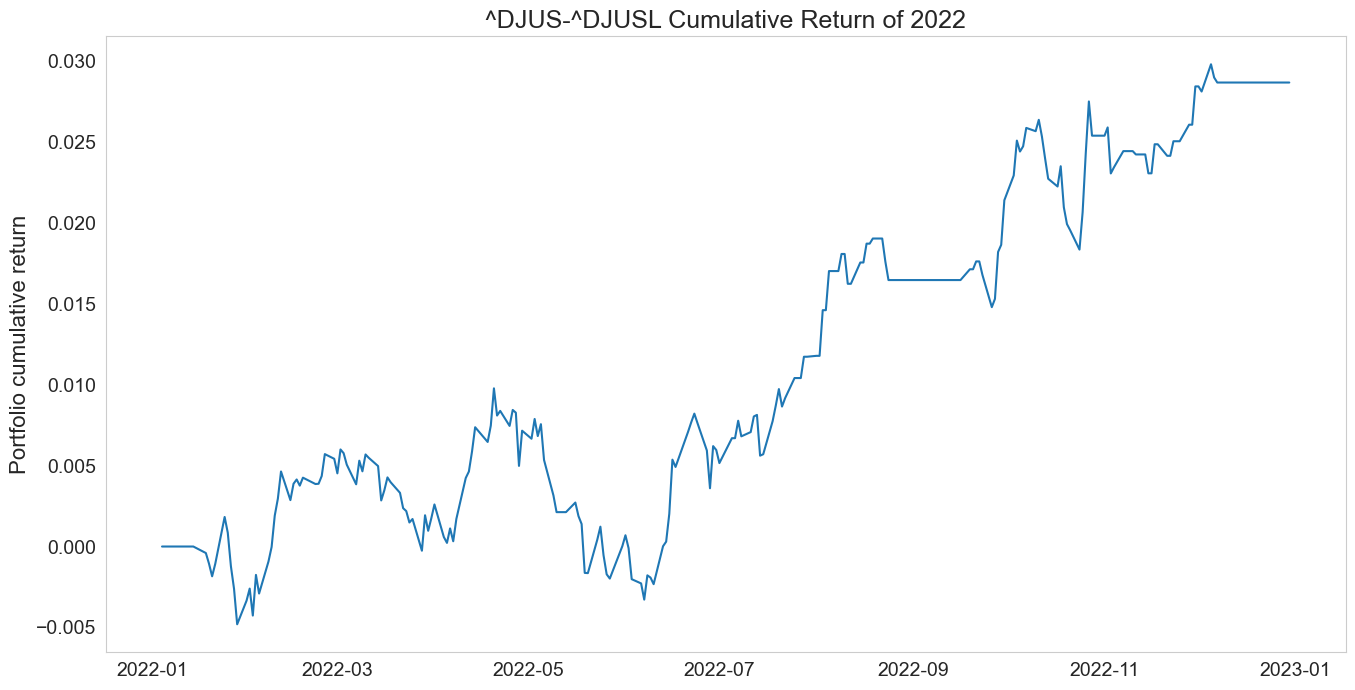

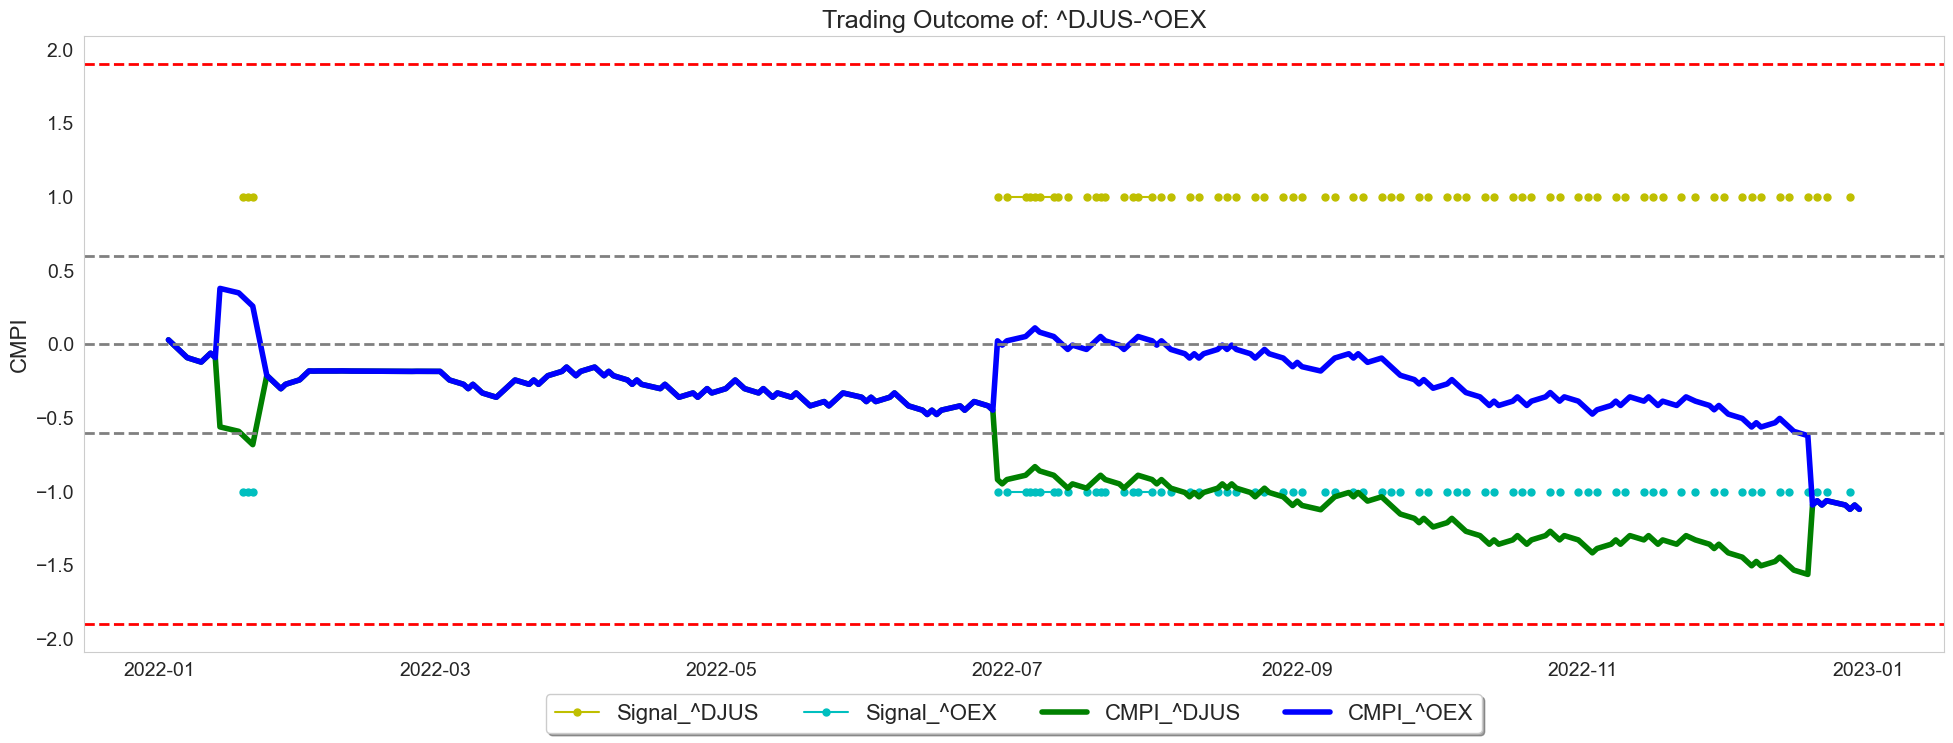

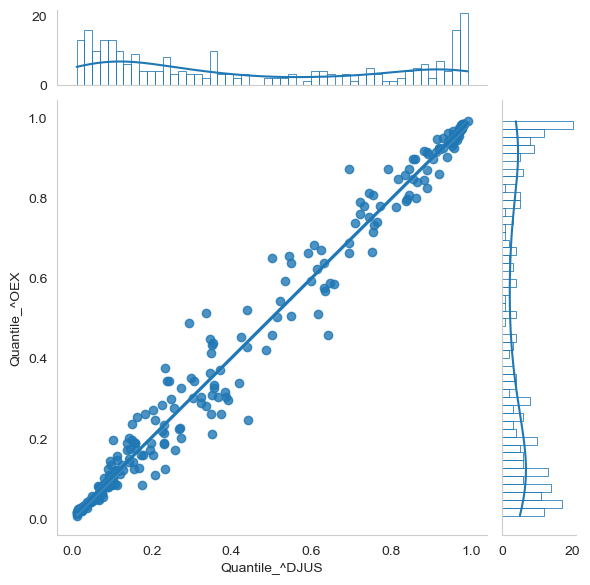

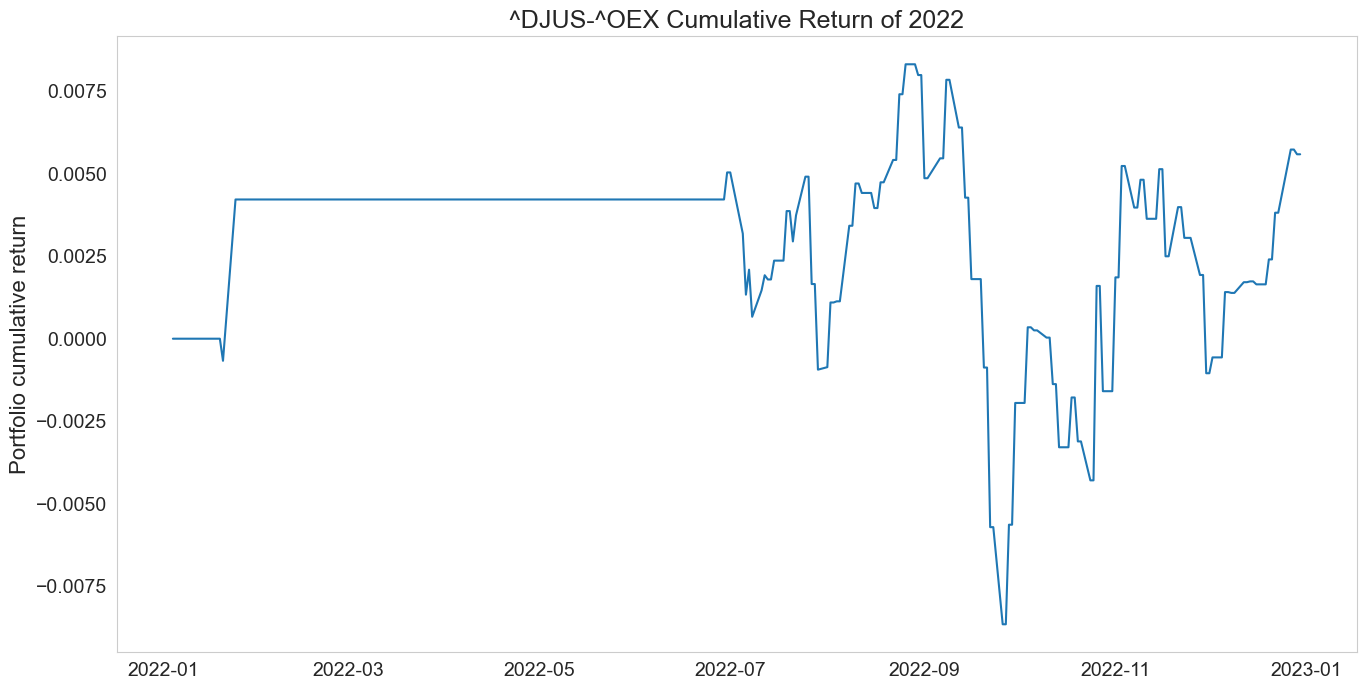

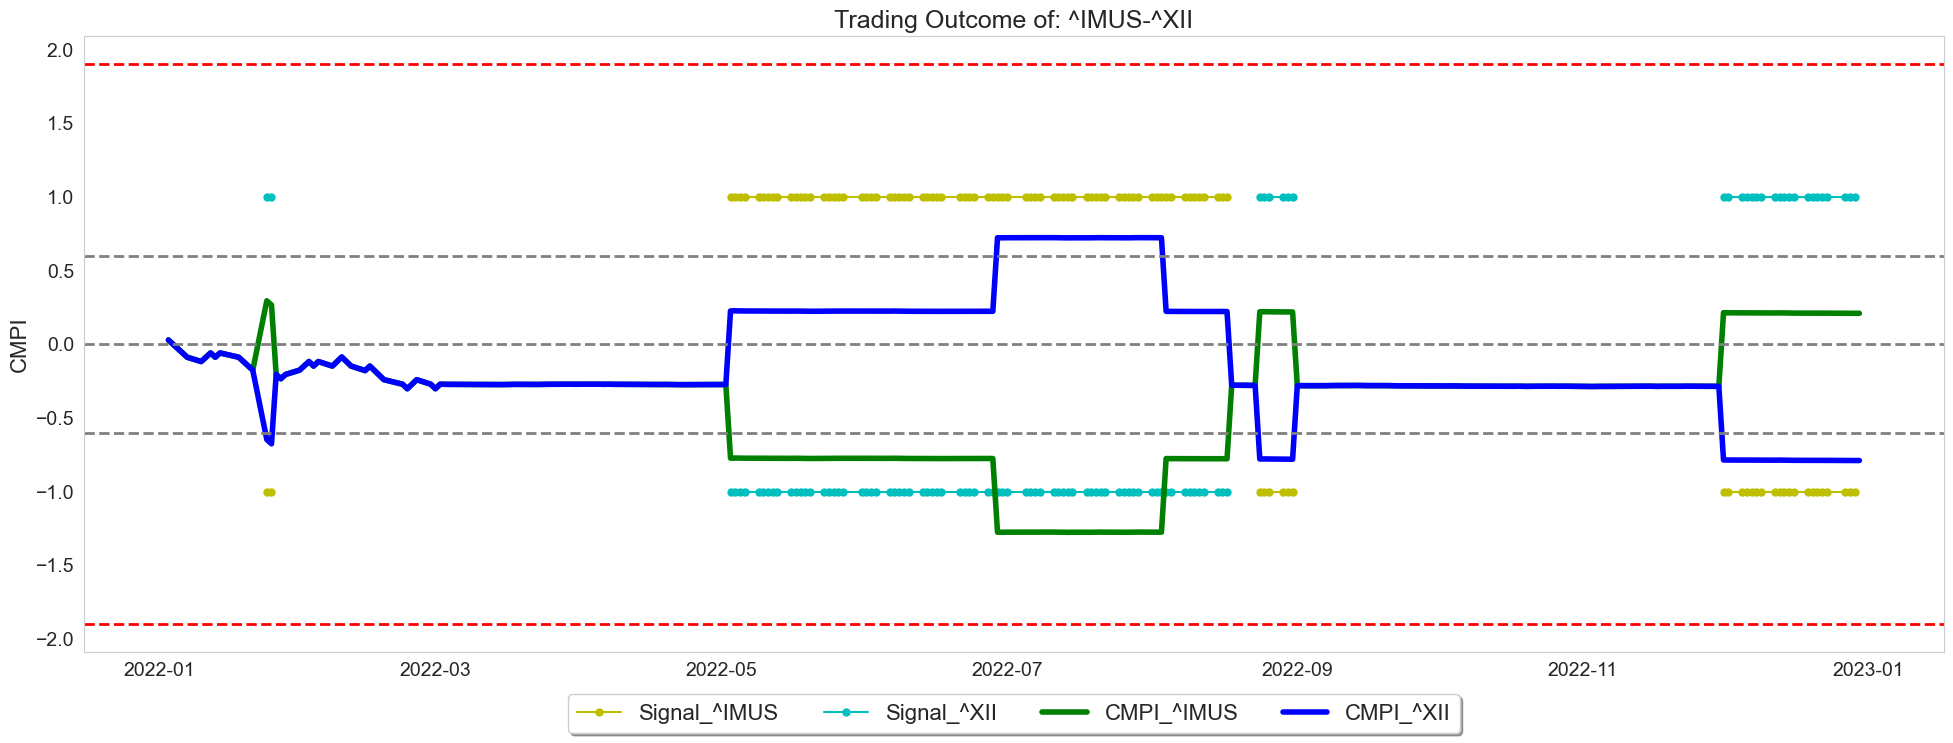

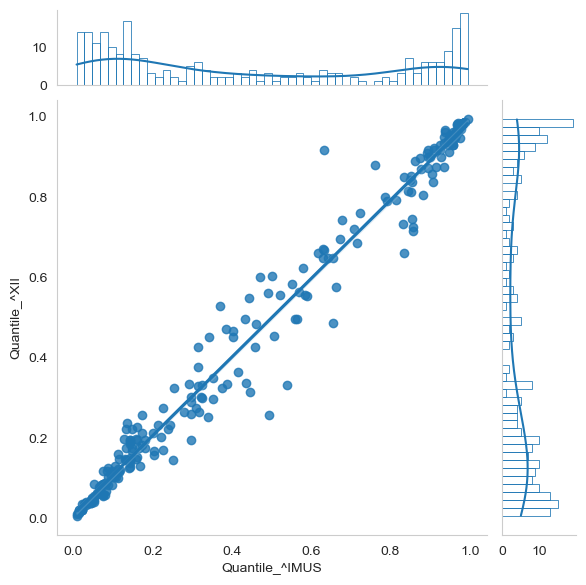

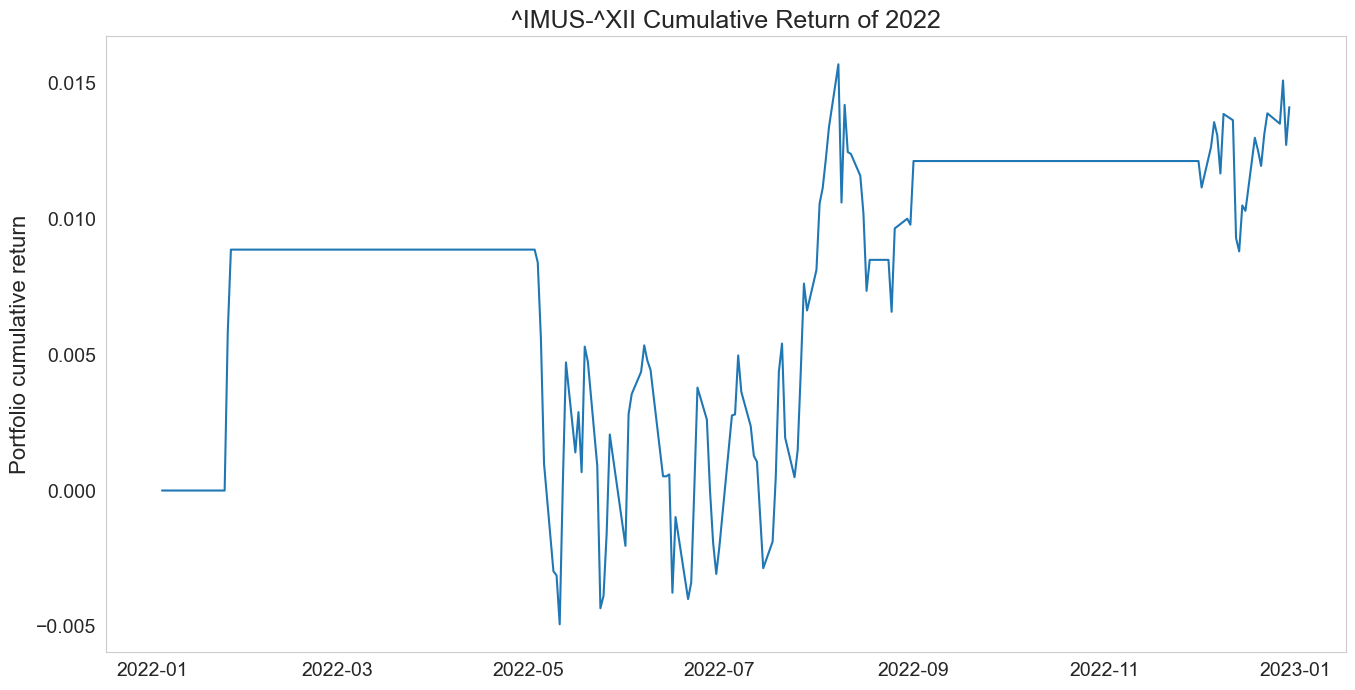

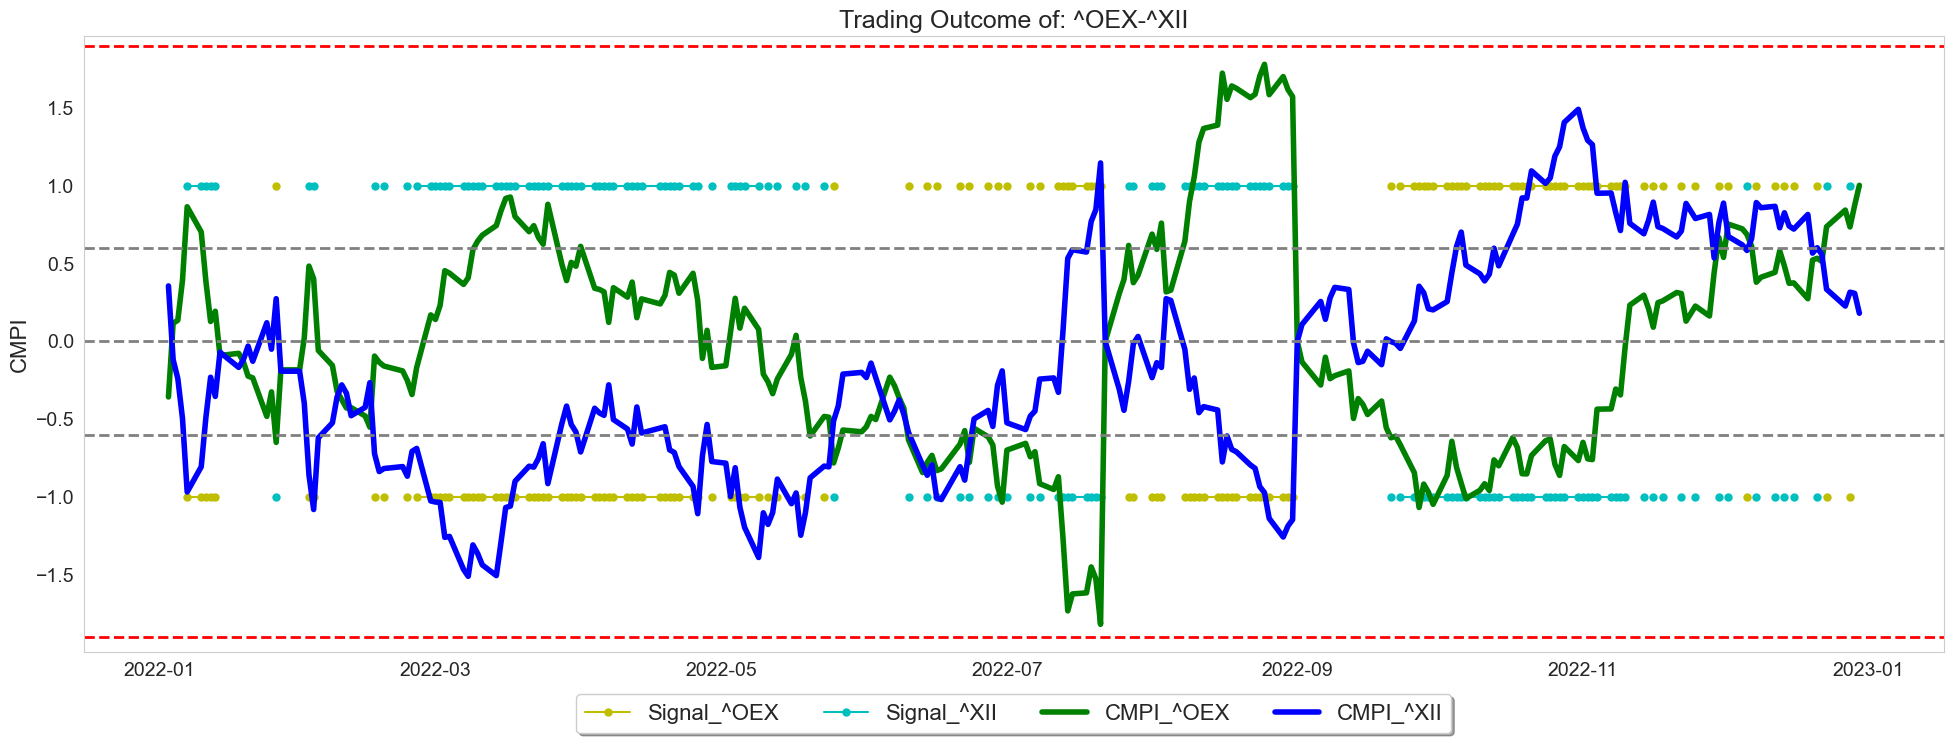

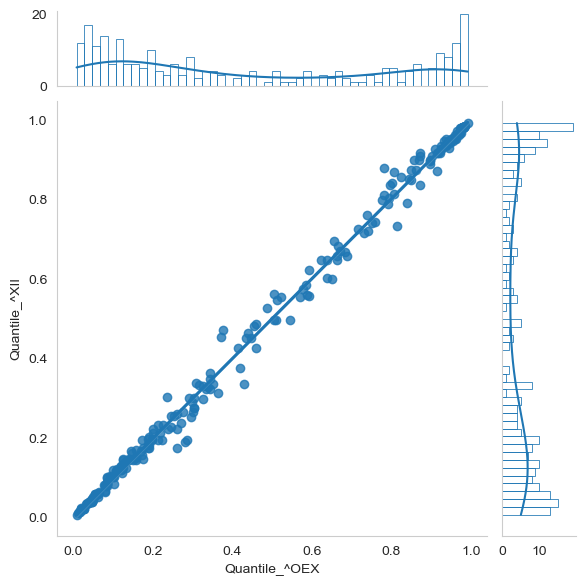

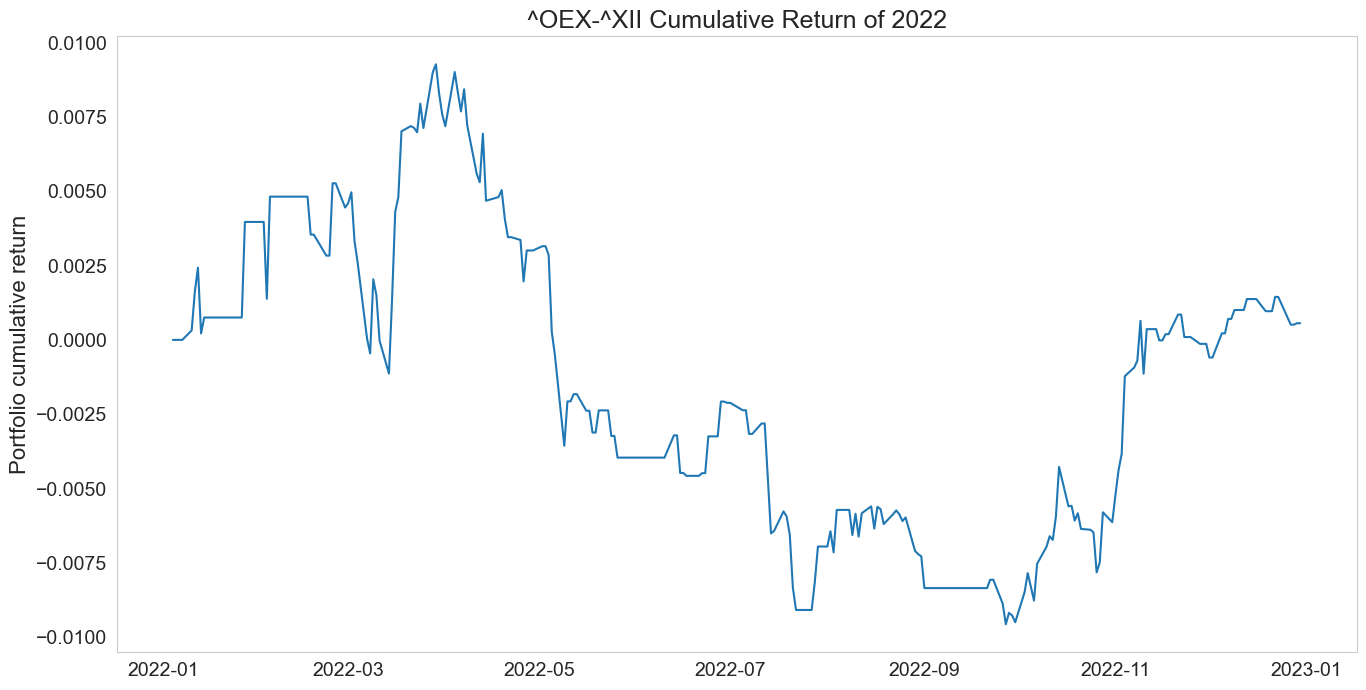

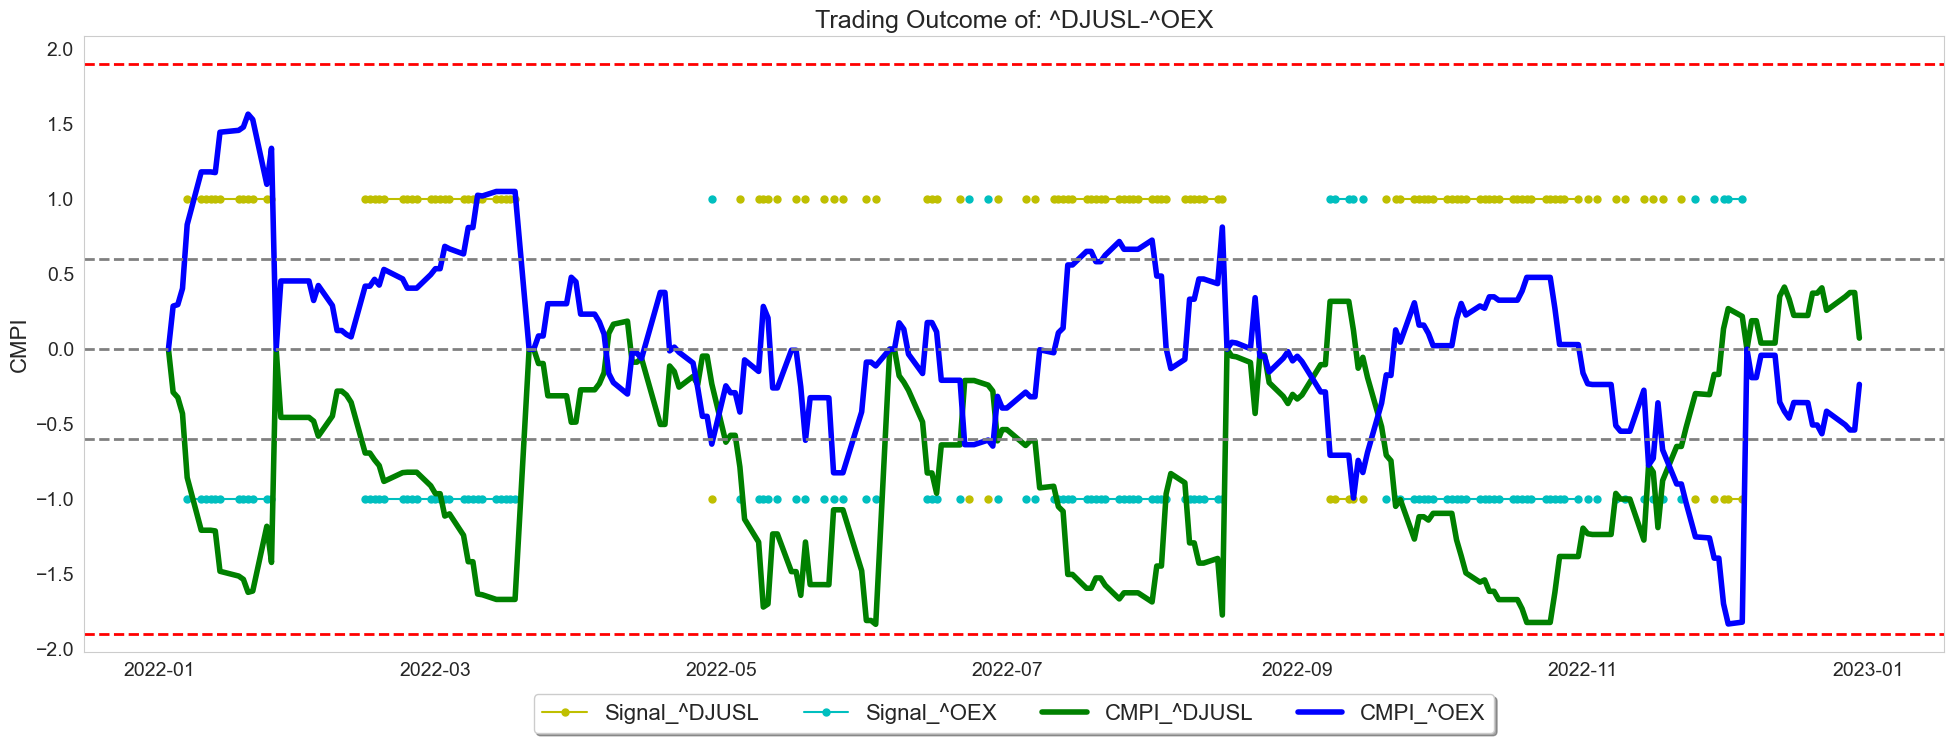

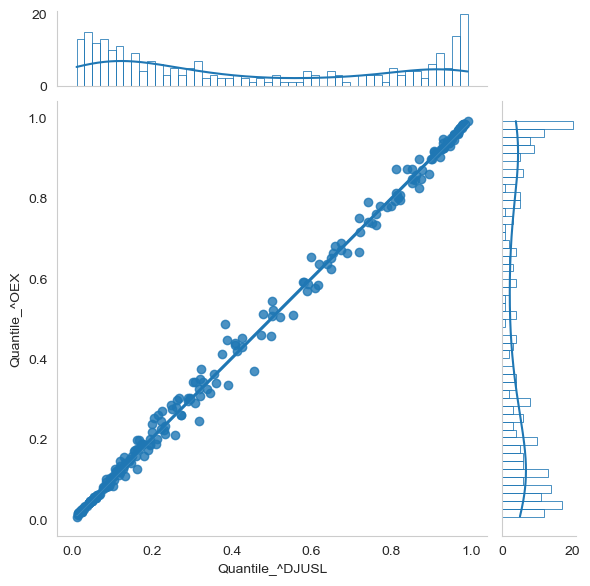

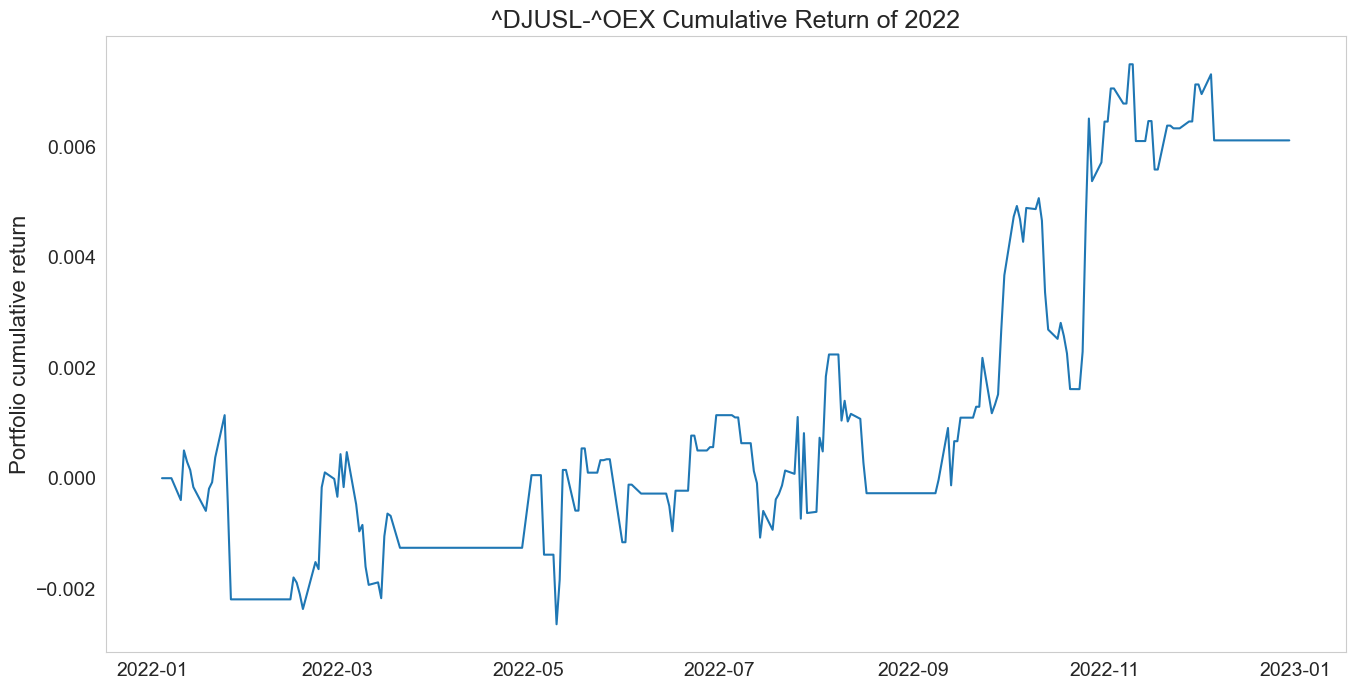

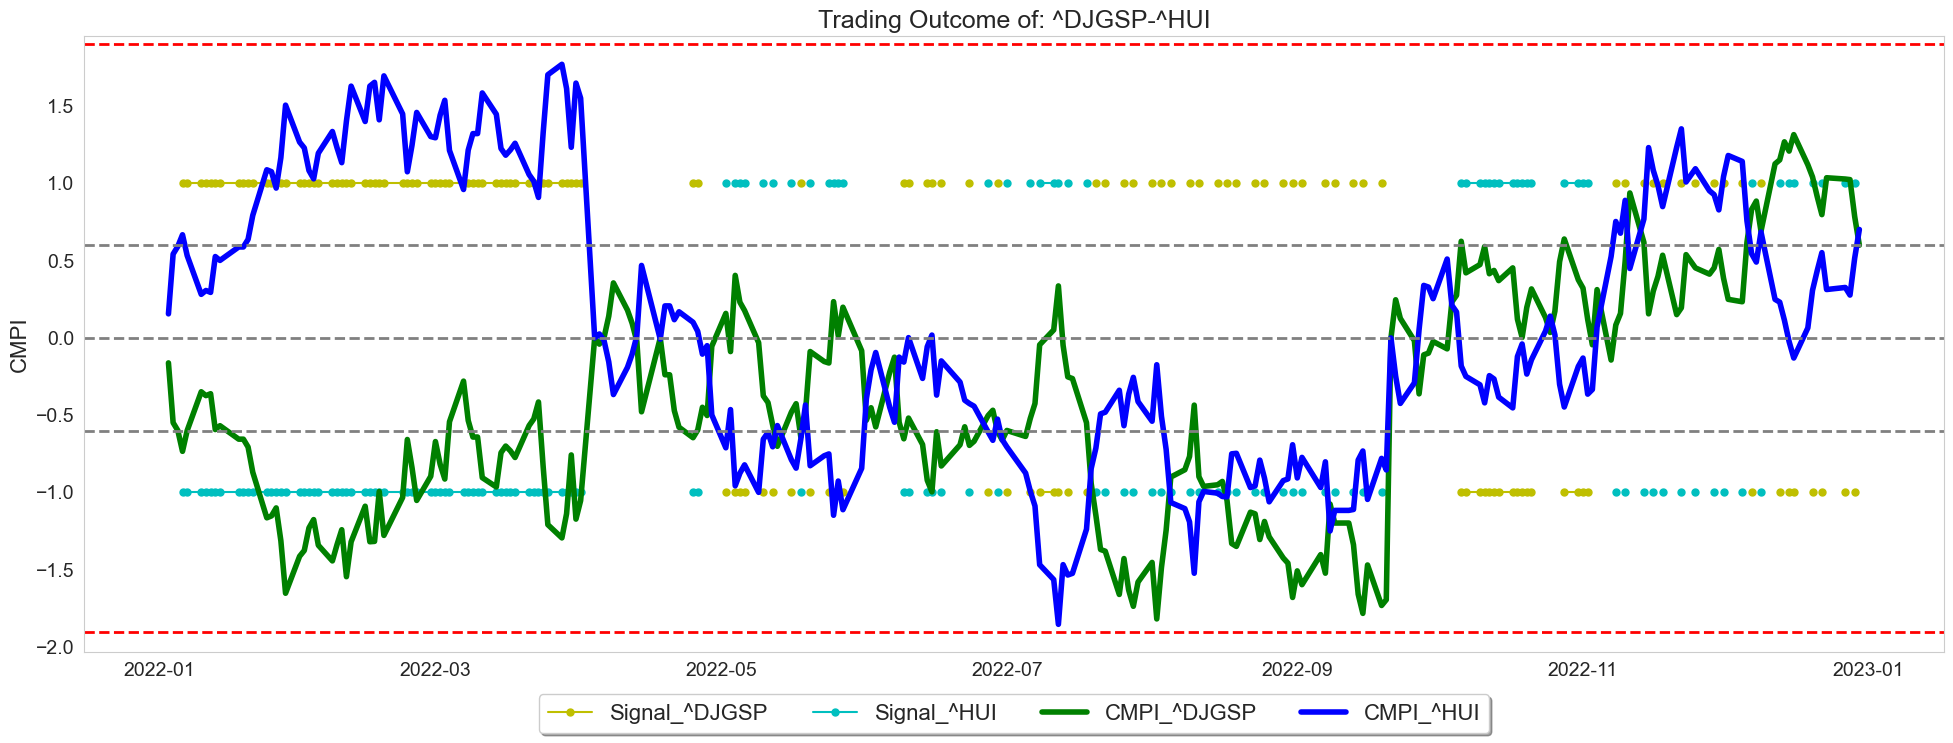

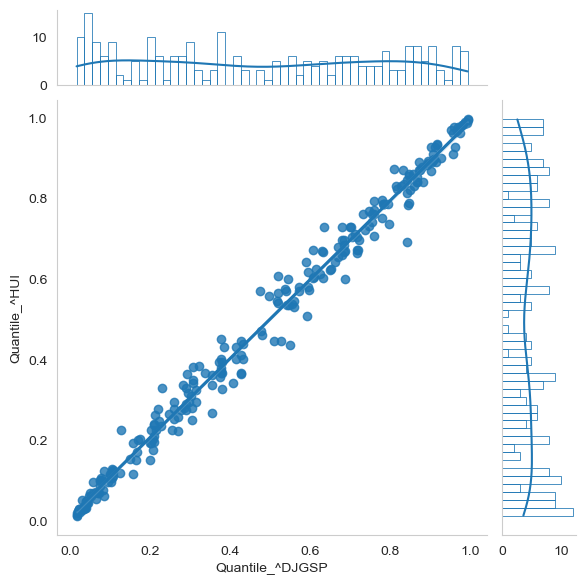

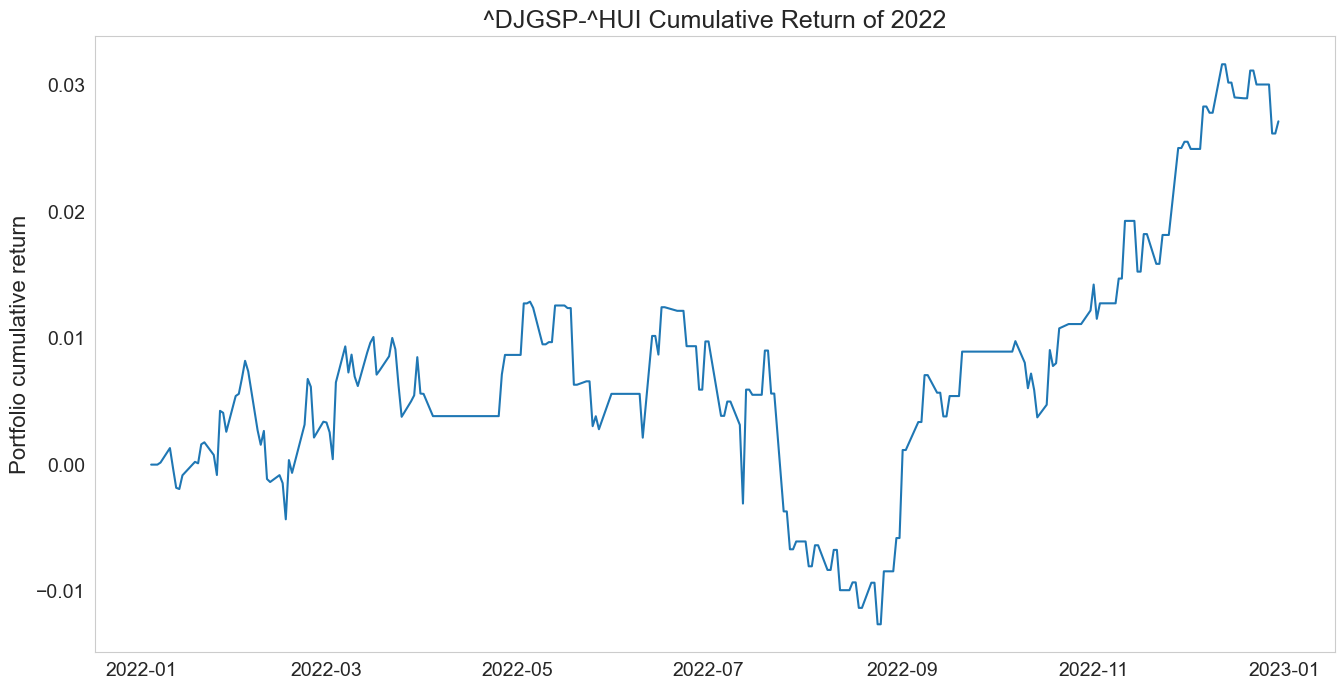

In [21]:
threshold = 0.6
trade_results = {}
df_pairs_metrics = pd.DataFrame(index=pairs_selected, columns=[
    'Cumulative Return', 'Sharpe Ratio', 'Max Drawdown', 'Maxnum Consecutive Losses',  'Winning Rate', 'Sortino Ratio'])

for pair in pairs_selected:
    stock_1, stock_2 = parse_pair(pair)
    df_calculations, df_positions, df_returns = copula_trading(
        df_data_form, df_data_trade, df_copula_results, pair, threshold)

    trade_results[pair] = {'calculations': df_calculations,
                           'positions': df_positions,
                           'returns': df_returns,
                           'metrics': metrics(df_returns.sum(axis=1))}
    df_pairs_metrics.loc[pair] = trade_results[pair]['metrics'].values[0].tolist()

    plt.figure(figsize=(24, 8))
    plt.grid(False)
    plt.title('Trading Outcome of: '+pair, fontsize=18)

    colors = ['y', 'c', 'g', 'b']
    for column, color in zip(trade_results[pair]['positions'].columns[:2], colors[:2]):
        plt.plot(trade_results[pair]['positions'][column].replace(
            0, np.nan), color=color, marker=".", markersize=10)
    for column, color in zip(trade_results[pair]['calculations'].columns[-2:], colors[2:]):
        plt.plot(trade_results[pair]['calculations']
                 [column], color=color, linewidth='4')
    plt.axhline(0.0, color='gray', linestyle='dashed', linewidth='2')
    plt.axhline(0.6, color='gray', linestyle='dashed', linewidth='2')
    plt.axhline(-0.6, color='gray', linestyle='dashed', linewidth='2')
    plt.axhline(1.9, color='r', linestyle='dashed', linewidth='2')
    plt.axhline(-1.9, color='r', linestyle='dashed', linewidth='2')
    plt.legend(['Signal_'+stock_1, 'Signal_' +
               stock_2, 'CMPI_'+stock_1, 'CMPI_'+stock_2], loc='upper center', fontsize='16', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=4)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('CMPI', fontsize=16)

    sns.jointplot(data=df_calculations.iloc[:, :2], x="Quantile_"+stock_1, y="Quantile_" +
                  stock_2, kind="reg", marginal_ticks=True, marginal_kws=dict(bins=50, fill=False))
    
    plt.figure(figsize=(16, 8))
    plt.grid(False)
    plt.plot(np.cumprod(df_returns.sum(axis=1)+1)-1)
    plt.title(pair+' Cumulative Return of 2022', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Portfolio cumulative return', fontsize=16)

trade_results


In [22]:
df_pairs_metrics.sort_values(
    by=['Sharpe Ratio', 'Cumulative Return'], ascending=False, inplace=True)
df_pairs_metrics


Cumulative Return Sharpe Ratio Max Drawdown  \
^IMUS-^OEX          0.05314776   1.74416639   0.01366779   
^DJUS-^DJUSL        0.02869053   1.50872590   0.01293711   
^DJUSL-^XII         0.02222110   1.37537946   0.00721670   
^DJUSS-^MID         0.03072824   1.08111259   0.02197310   
^DJGSP-^HUI         0.02712933   0.80741350   0.02517141   
^DJUSL-^OEX         0.00611117   0.68457372   0.00377872   
^IMUS-^XII          0.01412636   0.58806921   0.01368223   
^DJUS-^OEX          0.00558974   0.34422383   0.01683260   
^OEX-^XII           0.00056097   0.04695393   0.01865522   
^DJUSL-^IMUS       -0.00498927  -0.16159917   0.02882360   

             Maxnum Consecutive Losses Winning Rate Sortino Ratio  
^IMUS-^OEX                  3.00000000   0.24400000    0.15683338  
^DJUS-^DJUSL                5.00000000   0.37600000    0.13910004  
^DJUSL-^XII                 5.00000000   0.36400000    0.12073262  
^DJUSS-^MID                 5.00000000   0.38000000    0.09775041  
^DJGSP-^HUI                 3.00000000   0.30400000    0.07520822  
^DJUSL-^OEX                 4.00000000   0.26400000    0.06284539  
^IMUS-^XII                  6.00000000   0.20000000    0.05442124  
^DJUS-^OEX                  2.00000000   0.15200000    0.03148425  
^OEX-^XII                   5.00000000   0.30000000    0.00434773  
^DJUSL-^IMUS                4.00000000   0.26000000   -0.01354600

## Construct portfolio and measure performance

In [26]:
pairs_returns = []
for pair in pairs_selected:
    df_pair_return = trade_results[pair]['returns'].astype(float)
    pairs_returns.append(df_pair_return.sum(axis=1))

# all selected pairs are equally weighted
df_portfolio_return = pd.concat(pairs_returns, axis=1).mean(axis=1)
df_portfolio_metrics = metrics(df_portfolio_return).rename(
    index={'Metrics': 'Portfolio'})

pd.concat([df_pairs_metrics, df_portfolio_metrics], axis=0)


Cumulative Return Sharpe Ratio Max Drawdown  \
^IMUS-^OEX          0.05314776   1.74416639   0.01366779   
^DJUS-^DJUSL        0.02869053   1.50872590   0.01293711   
^DJUSL-^XII         0.02222110   1.37537946   0.00721670   
^DJUSS-^MID         0.03072824   1.08111259   0.02197310   
^DJGSP-^HUI         0.02712933   0.80741350   0.02517141   
^DJUSL-^OEX         0.00611117   0.68457372   0.00377872   
^IMUS-^XII          0.01412636   0.58806921   0.01368223   
^DJUS-^OEX          0.00558974   0.34422383   0.01683260   
^OEX-^XII           0.00056097   0.04695393   0.01865522   
^DJUSL-^IMUS       -0.00498927  -0.16159917   0.02882360   
Portfolio           0.01844309   2.29702217   0.00428038   

             Maxnum Consecutive Losses Winning Rate Sortino Ratio  
^IMUS-^OEX                  3.00000000   0.24400000    0.15683338  
^DJUS-^DJUSL                5.00000000   0.37600000    0.13910004  
^DJUSL-^XII                 5.00000000   0.36400000    0.12073262  
^DJUSS-^MID                 5.00000000   0.38000000    0.09775041  
^DJGSP-^HUI                 3.00000000   0.30400000    0.07520822  
^DJUSL-^OEX                 4.00000000   0.26400000    0.06284539  
^IMUS-^XII                  6.00000000   0.20000000    0.05442124  
^DJUS-^OEX                  2.00000000   0.15200000    0.03148425  
^OEX-^XII                   5.00000000   0.30000000    0.00434773  
^DJUSL-^IMUS                4.00000000   0.26000000   -0.01354600  
Portfolio                            6   0.55600000    0.20526244

Text(0, 0.5, 'Portfolio cumulative return')

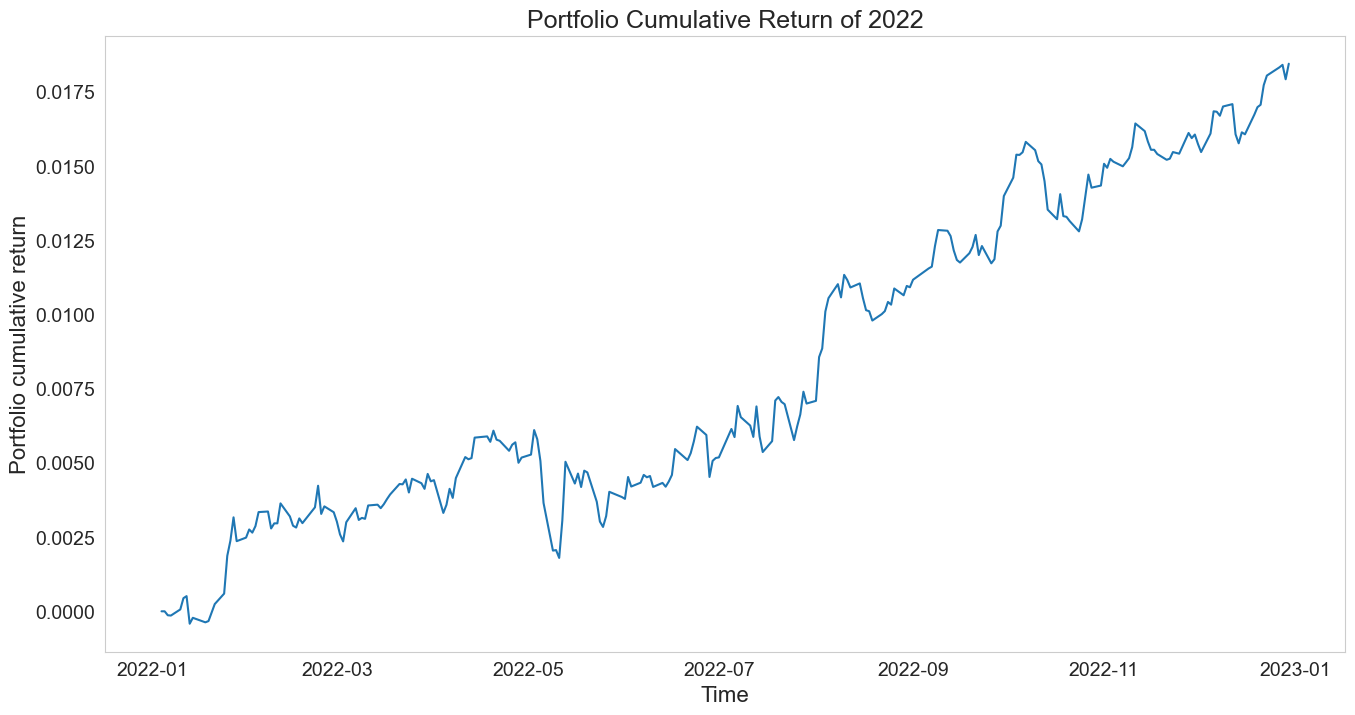

In [25]:
# plot portfolio cumulative return
plt.figure(figsize=(16, 8), facecolor='white')
plt.grid(False)
profit_cum = (np.cumprod(df_portfolio_return+1)-1)
plt.plot(profit_cum)
plt.title('Portfolio Cumulative Return of 2022', fontsize=18)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Portfolio cumulative return', fontsize=16)
